# qPCR timecourse

In [1]:
import pandas as pd
import plotnine as pn

from scipy.stats import sem
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import f_oneway
from scipy.stats import kruskal

Functions

In [2]:
phages=["bop","car","ccs1","ccs2","ccs3","ump","carl","bill","ben","sds1","sds2","pg2","pg9","pg11","pg13","v12"]
phage_to_upper = {"bop":"Bop",
                 "car":"Car",
                 "ccs1":"CCS1",
                 "ccs2":"CCS2",
                 "ccs3":"CCS3",
                 "ump":"Ump",
                 "carl":"Carl",
                 "bill":"Bill",
                 "ben":"Ben",
                 "sds1":"SDS1",
                 "sds2":"SDS2",
                 "pg2":"PG2",
                 "pg9":"PG9",
                 "pg11":"PG11",
                 "pg13":"PG13",
                 "v12":"V12"}
phage_order = ["V12","Bop","Ben","Bill","Car","Carl","CCS1","SDS1","SDS2","CCS2","CCS3","PG2","PG9","PG11","PG13","Ump"]

def parse_phages(text):
    '''
    Takes in a text string with phages in it and returns a list of the phages
    '''
    text_lower = str.lower(text)
    phage_list = []
    #Deal with car and carl
    if "carl" in text_lower:
        phage_list.append("carl")
        text_lower = text_lower.replace("carl","")
    for phage in phages:
        if phage in text_lower:
            phage_list.append(phage)
    phage_list = [phage_to_upper[x] for x in phage_list]
    return(phage_list)

def mean(x):
    return(sum(x)/len(x))

Import qpcr data

In [3]:
#Import data
file = "data/qpcr_timepoint.txt"
raw_dat = pd.read_table(file)

#Format data
##Parse phages
raw_dat["Phage"] = raw_dat.cocktail.apply(func=parse_phages)
##Count phages
raw_dat["num_phages"] = raw_dat.Phage.apply(func=lambda x: len(x))
##Format time
raw_dat["timepoint"] = [int(x.strip("h")) for x in raw_dat.timepoint]
raw_dat = raw_dat.melt(id_vars = ['host','cocktail','condition','phage_measured','timepoint','Phage','num_phages'], 
                       value_vars = ["value1","value2","value3"],
                      var_name = "replicate")
raw_dat["cocktail_name"] = ["Cocktail " + str(x.split()[-2]) for x in raw_dat.cocktail]

raw_dat.head(4)

,host,cocktail,condition,phage_measured,timepoint,Phage,num_phages,replicate,value,cocktail_name
0,YI6,Yi6-1_Cocktail 1 (Carl+Ben+CCS2),with host,CCS2,0,"[Carl, CCS2, Ben]",3,value1,8.262565,Cocktail 1
1,YI6,Yi6-1_Cocktail 1 (Carl+Ben+CCS2),with host,CCS2,24,"[Carl, CCS2, Ben]",3,value1,9.104303,Cocktail 1
2,YI6,Yi6-1_Cocktail 1 (Carl+Ben+CCS2),with host,CCS2,48,"[Carl, CCS2, Ben]",3,value1,9.493282,Cocktail 1
3,YI6,Yi6-1_Cocktail 1 (Carl+Ben+CCS2),with host,CCS2,72,"[Carl, CCS2, Ben]",3,value1,9.355837,Cocktail 1


Format qpcr data  
Subtract timepoint 0 of cocktail condition.

In [4]:
def subtraction_func2(row):
    '''
    Subtract the time 0 timepoint from the phage-cocktail condition.
    '''
    cocktail=row.cocktail_name
    phage = row["phage_measured"]
    timepoint = row.timepoint
    tp0_val = raw_dat.query('phage_measured == @phage & condition == "with host" & cocktail_name == @cocktail & timepoint == 0').value.mean()
    return(tp0_val)

with_host_minus_tp0 = raw_dat.query('condition=="with host"').copy()
with_host_minus_tp0["tp0_mean"] = with_host_minus_tp0.apply(axis=1, func=subtraction_func2)
with_host_minus_tp0["value_minus_tp0"] = with_host_minus_tp0.apply(axis=1, func= lambda row: row.value - row.tp0_mean)

def format_cocktail_title(row):
    out = ''
    out +=  ' , '.join(row.Phage)
    return(out)

with_host_minus_tp0["formatted_cocktail_name"] = with_host_minus_tp0.apply(axis=1, func=format_cocktail_title)

phage_type_dict = {"Bop":"M",
                 "Car":"M",
                 "CCS1":"M",
                 "CCS2":"S",
                 "CCS3":"S",
                 "Ump":"P",
                 "Carl":"M",
                 "Bill":"M",
                 "Ben":"M",
                 "SDS1":"S",
                 "SDS2":"S",
                 "PG2":"S",
                 "PG9":"S",
                 "PG11":"S",
                 "PG13":"S",
                 "V12":"M"}
phage_order = ["V12","Bop","Ben","Bill","Car","Carl","CCS1","SDS1","SDS2","CCS2","CCS3","PG2","PG9","PG11","PG13","Ump"]
phage_subtype = {x:"{}({})".format(x,phage_type_dict[x]) for x in phage_order}


qpcr_plot_dat = with_host_minus_tp0.copy()
#Mean and err
qpcr_plot_dat = qpcr_plot_dat.groupby(["cocktail_name","timepoint","phage_measured"])\
    .agg({'value_minus_tp0':[mean,np.std ],
         "formatted_cocktail_name":"first"})\
    .reset_index()
qpcr_plot_dat.columns = ["Cocktail","timepoint","phage_measured","value","err","formatted_cocktail_name"]
qpcr_plot_dat["errp"] = qpcr_plot_dat.apply(axis=1, func = lambda row: row.value + row.err)
qpcr_plot_dat["errn"] = qpcr_plot_dat.apply(axis=1, func = lambda row: row.value - row.err)
qpcr_plot_dat["phage_measured"] = [phage_subtype[x] for x in qpcr_plot_dat.phage_measured]
qpcr_plot_dat["phage_measured"] = pd.Categorical(qpcr_plot_dat["phage_measured"],
                                            categories=["Ben(M)","Bill(M)","Carl(M)","CCS1(M)", "CCS2(S)","SDS1(S)","Ump(P)"])


Format qpcr data  
Subtract same timepoint of nohost condition

In [5]:
mean_nohost_df = raw_dat.query('condition=="no host"')\
                            .groupby(["cocktail_name","timepoint","phage_measured"])\
                            .agg({'value':[mean,sem ]})\
                            .reset_index()
mean_nohost_df.columns = ["cocktail_name", "timepoint","phage_measured","val","err"]


def subtraction_func(row):
    '''
    Subtract the mean of the phage-only control for that specific timepoint.
    '''
    cocktail=row.cocktail_name
    phage = row["phage_measured"]
    timepoint = row.timepoint
    mean_nohost_val = float(mean_nohost_df.query('phage_measured == @phage & cocktail_name == @cocktail & timepoint == @timepoint').val)
    return(mean_nohost_val)

def subtraction_func2(row):
    '''
    Subtract the time 0 timepoint from the phage-cocktail condition.
    '''
    cocktail=row.cocktail_name
    phage = row["phage_measured"]
    timepoint = row.timepoint
    tp0_val = raw_dat.query('phage_measured == @phage & cocktail_name == @cocktail & timepoint == 0').value.mean()
    return(tp0_val)

with_host_minus_nohost = raw_dat.query('condition=="with host"').copy()
with_host_minus_nohost["nohost_mean"] = with_host_minus_nohost.apply(axis=1, func=subtraction_func)
with_host_minus_nohost["value_minus_nohost"] = with_host_minus_nohost.apply(axis=1, func= lambda row: row.value - row.nohost_mean)

def format_cocktail_title(row):
    out = ''
    out +=  ' , '.join(row.Phage)
    return(out)

with_host_minus_nohost["formatted_cocktail_name"] = with_host_minus_nohost.apply(axis=1, func=format_cocktail_title)

phage_type_dict = {"Bop":"M",
                 "Car":"M",
                 "CCS1":"M",
                 "CCS2":"S",
                 "CCS3":"S",
                 "Ump":"P",
                 "Carl":"M",
                 "Bill":"M",
                 "Ben":"M",
                 "SDS1":"S",
                 "SDS2":"S",
                 "PG2":"S",
                 "PG9":"S",
                 "PG11":"S",
                 "PG13":"S",
                 "V12":"M"}
phage_order = ["V12","Bop","Ben","Bill","Car","Carl","CCS1","SDS1","SDS2","CCS2","CCS3","PG2","PG9","PG11","PG13","Ump"]
phage_subtype = {x:"{}({})".format(x,phage_type_dict[x]) for x in phage_order}


qpcr_plot_dat_minus_nohost = with_host_minus_nohost.copy()
#Mean and err
qpcr_plot_dat_minus_nohost = qpcr_plot_dat_minus_nohost.groupby(["cocktail_name","timepoint","phage_measured"])\
    .agg({'value_minus_nohost':[mean,np.std ],
         "formatted_cocktail_name":"first"})\
    .reset_index()
qpcr_plot_dat_minus_nohost.columns = ["Cocktail","timepoint","phage_measured","value","err","formatted_cocktail_name"]
qpcr_plot_dat_minus_nohost["errp"] = qpcr_plot_dat_minus_nohost.apply(axis=1, func = lambda row: row.value + row.err)
qpcr_plot_dat_minus_nohost["errn"] = qpcr_plot_dat_minus_nohost.apply(axis=1, func = lambda row: row.value - row.err)
qpcr_plot_dat_minus_nohost["phage_measured"] = [phage_subtype[x] for x in qpcr_plot_dat_minus_nohost.phage_measured]
qpcr_plot_dat_minus_nohost["phage_measured"] = pd.Categorical(qpcr_plot_dat_minus_nohost["phage_measured"],
                                            categories=["Ben(M)","Bill(M)","Carl(M)","CCS1(M)", "CCS2(S)","SDS1(S)","Ump(P)"])


Import OD

In [6]:
#Import OD values
od_sheets = pd.read_excel('data/Pride_qpcr/OD_formatted.xlsx', sheet_name=None)
od_file = pd.concat([v for k,v in od_sheets.items()])


#Subtract blank
blank_val = mean(od_file.negative1.append(od_file.negative2).append(od_file.negative3))
for col in ['value1', 'value2','value3','phage_only1','phage_only2','phage_only3','host_only1','host_only2','host_only3']:
    od_file[col] = od_file[col] - blank_val

#Format data
def get_avg(row):
    #Get values
    values = [row.value1, row.value2, row.value3]
    phage_values = [row.phage_only1, row.phage_only2, row.phage_only3]
    host_values = [row.host_only1, row.host_only2, row.host_only3]
    #Get averages
    row["value_avg"] = mean(values)
    row["phage_avg"] = mean(phage_values)
    row["host_avg"] = mean(host_values)
    #Get SDs
    row["value_sd"] = np.std(values)
    row["phage_sd"] = np.std(phage_values)
    row["host_sd"] = np.std(host_values)
    #SEMs
    row["value_sem"] = sem(values)
    row["phage_sem"] = sem(phage_values)
    row["host_sem"] = sem(host_values)
    return(row)
od_file = od_file.apply(axis=1, func=get_avg)

od_file = od_file.reset_index()
od_file["Hour"] = [round(x,4) for x in od_file.Hour]


excludes = [23.9167, 24.0000, 24.0833,24.1667, 24.2500,24.3333,
            47.9167, 48.0000, 48.0833, 48.1667, 48.2500, 48.3333, 48.4167, 48.5000, 48.5833]
od_plot_dat = od_file.query('Hour not in @excludes').copy()

od_plot_dat["cocktail_long"] = od_plot_dat["Cocktail"]
od_plot_dat["Cocktail"] = ["Cocktail " + str(x.split()[1][0]) for x in od_plot_dat.cocktail_long]

Calculate stats

In [7]:
out_list = []
cocktail_list = ["Cocktail " + str(j) for j in range(1,9)]
for cocktail in cocktail_list:
    for hour in [0,24,48,72]:
        value_list = []
        dat_ss = with_host_minus_nohost.query('cocktail_name == @cocktail & timepoint==@hour')
        phages = set(dat_ss.phage_measured)
        for phage in phages:
            value_list.append( dat_ss.query('phage_measured== @phage').value_minus_nohost.values )
        anova = kruskal(*value_list)
        out_list.append([cocktail, hour, anova.statistic, anova.pvalue])

minusnohost_anova_df = pd.DataFrame(out_list, columns=["Cocktail","Hour","stat","pvalue"])
minusnohost_anova_df["sig"] = [x<0.05 for x in minusnohost_anova_df.pvalue]
minusnohost_anova_df_sig = minusnohost_anova_df.query('sig==True')
minusnohost_anova_df.head(4)

,Cocktail,Hour,stat,pvalue,sig
0,Cocktail 1,0,0.622222,0.732632,False
1,Cocktail 1,24,3.822222,0.147916,False
2,Cocktail 1,48,5.600000,0.060810,False
3,Cocktail 1,72,5.600000,0.060810,False


In [8]:
out_list = []
cocktail_list = ["Cocktail " + str(j) for j in range(1,9)]
for cocktail in cocktail_list:
    for hour in [0,24,48,72]:
        value_list = []
        dat_ss = with_host_minus_tp0.query('cocktail_name == @cocktail & timepoint==@hour')
        phages = set(dat_ss.phage_measured)
        for phage in phages:
            value_list.append( dat_ss.query('phage_measured== @phage').value_minus_tp0.values )
        anova = kruskal(*value_list)
        out_list.append([cocktail, hour, anova.statistic, anova.pvalue])

anova_df = pd.DataFrame(out_list, columns=["Cocktail","Hour","stat","pvalue"])
anova_df["sig"] = [x<0.05 for x in anova_df.pvalue]
anova_df_sig = anova_df.query('sig==True')
anova_df.head(4)

,Cocktail,Hour,stat,pvalue,sig
0,Cocktail 1,0,0.355556,0.837128,False
1,Cocktail 1,24,3.822222,0.147916,False
2,Cocktail 1,48,4.622222,0.099151,False
3,Cocktail 1,72,1.866667,0.393241,False


## Plot

Plot "phage only" wells over time to ensure nothing weird is happening

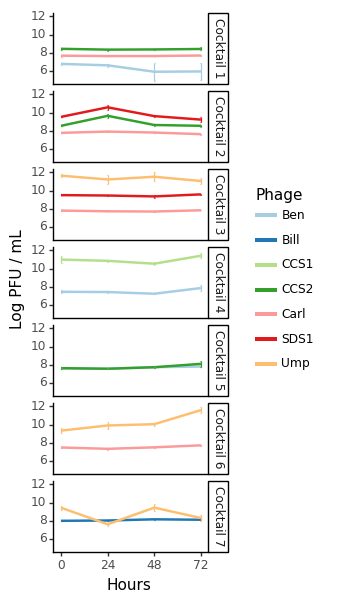

<ggplot: (8747657753986)>

In [125]:
plot_dat = raw_dat.query('condition=="no host"').copy()
plot_dat = plot_dat.groupby(["cocktail_name","timepoint","phage_measured"])\
    .agg({'value':[mean,sem ]})\
    .reset_index()
plot_dat.columns = ["Cocktail","timepoint","phage_measured","value","err"]
plot_dat["errp"] = plot_dat.apply(axis=1, func = lambda row: row.value + row.err)
plot_dat["errn"] = plot_dat.apply(axis=1, func = lambda row: row.value - row.err)

colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']

pn.options.figure_size = (2,7)

p = ( pn.ggplot( data = plot_dat) +
    pn.geom_line( pn.aes(x= "timepoint", y="value", color="phage_measured" ), size=1) +
     pn.geom_errorbar( pn.aes(x = "timepoint",  ymin = "errn", ymax = "errp", color="phage_measured")) +
     pn.scale_x_continuous(breaks = [0,24,48,72]) +
     pn.scale_color_manual(colors) +
     pn.labs(x="Hours", y="Log PFU / mL", color="Phage") +
     pn.facet_grid("Cocktail~.") +
     pn.theme_classic()
    
    )
p

Plot rough OD

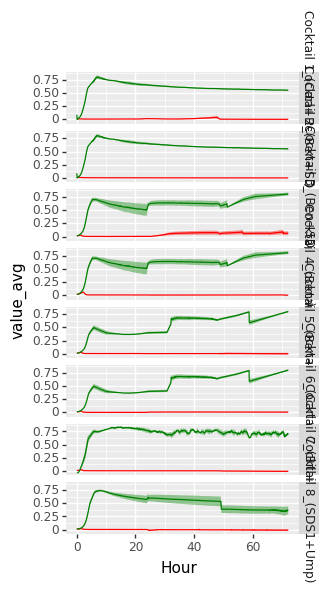

<ggplot: (8755339406538)>

In [154]:
pn.options.figure_size = (3, 6)

plot_dat = od_file.copy()
plot_dat = plot_dat.query('Hour not in @excludes')

p = (pn.ggplot( data = plot_dat) +
     pn.geom_line( pn.aes( x= "Hour", y="value_avg"), color="red") +
     pn.geom_line( pn.aes( x= "Hour", y="host_avg"), color="green") +
     pn.geom_ribbon( pn.aes( x= "Hour", ymin="host_avg-host_sem", ymax="host_avg+host_sem"), fill="green", color=None, alpha=.4) +
    pn.geom_ribbon( pn.aes( x= "Hour", ymin="value_avg-value_sem", ymax="value_avg+value_sem"), fill="red", color=None, alpha=.4) +

     pn.facet_grid('Cocktail~.')
    )
p

# Final Figure

Minus nohost.  
with stats

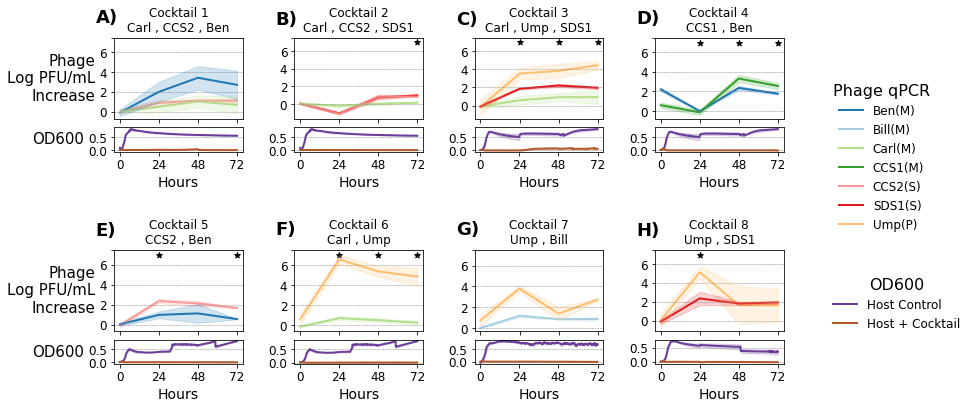

In [30]:
RIBBON_ALPHA=0.2
SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS = 1

phage_color_dict= {"Ben(M)":'#1f78b4',
                  "Bill(M)":'#a6cee3',
                  "Carl(M)":'#b2df8a',
                  "CCS1(M)":'#33a02c',
                  "CCS2(S)":'#fb9a99',
                  "SDS1(S)":'#e31a1c',
                  "Ump(P)":'#fdbf6f'}
od_color_dict={"Host Control":"#6a3d9a",
              "Host + Cocktail":"#b15928"}

fig,axs =  plt.subplots(5,4,
                        figsize=(12,6),
                       gridspec_kw={'height_ratios': [1, .3,SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS, 1, .3]})

fig.subplots_adjust(wspace=.4, hspace=.15)
for j in [0,1,2,3]:
    axs[2,j].set_visible(False)

cocktail_list = ["Cocktail " + str(j) for j in range(1,9)]

for i, cocktail in enumerate(cocktail_list):
    j=0
    if i > 3:
        i-=4
        j+=3
    #Subset data
    od_dat_ss = od_plot_dat.query('Cocktail == @cocktail')
    qpcr_dat_ss = qpcr_plot_dat_minus_nohost.query('Cocktail == @cocktail')
    
    #Get x values
    od_x = od_dat_ss.Hour.values
    
    #Get y values for qpcr
    phage_y_values = {}
    phage_y_errp = {}
    phage_y_errn = {}
    phage_x = {}
    for phage in set(qpcr_dat_ss.phage_measured):
        #Subset data
        phage_ss = qpcr_dat_ss.query('phage_measured == @phage')
        #Get x values
        phage_x[phage] = phage_ss.timepoint.values
        #Get y values
        phage_y_values[phage] = phage_ss.value.values
        #Get y error
        phage_y_errp[phage] = phage_ss.errp.values
        phage_y_errn[phage] = phage_ss.errn.values
        #Get colors
        color_ = phage_color_dict[phage]
        
        #Plot error
        axs[j,i].fill_between(phage_x[phage], phage_y_errn[phage], phage_y_errp[phage], 
                              color= color_, alpha=RIBBON_ALPHA, zorder=2)
        
        #Plot line
        axs[j,i].plot(phage_x[phage],phage_y_values[phage], 
                      color=color_, zorder=1, linewidth=2)
        
        
    
    #Get y values for OD
    od_control_y = od_dat_ss.host_avg.values
    od_cocktail_y = od_dat_ss.value_avg.values
    #Get errors for OD
    od_control_y_sem = od_dat_ss.host_sem.values
    od_cocktail_y_sem = od_dat_ss.value_sem.values
    
    #Plot OD line
    axs[j+1,i].plot(od_x, od_control_y,  color=od_color_dict["Host Control"], linewidth=2)
    axs[j+1,i].plot(od_x, od_cocktail_y, color=od_color_dict["Host + Cocktail"], linewidth=2)
    
    #Plor OD error
    axs[j+1,i].fill_between(od_x, od_control_y - od_control_y_sem, od_control_y + od_control_y_sem, 
                            color=od_color_dict["Host Control"], alpha=RIBBON_ALPHA)
    axs[j+1,i].fill_between(od_x, od_cocktail_y - od_cocktail_y_sem, od_cocktail_y + od_cocktail_y_sem,
                            color=od_color_dict["Host + Cocktail"], alpha=RIBBON_ALPHA)
    
    #Qpcr title
    title_text = qpcr_dat_ss.Cocktail.values[0] + "\n" +  qpcr_dat_ss.formatted_cocktail_name.values[0]        
    axs[j,i].set_title(title_text)
    #axis grid
    axs[j,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    axs[j+1,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    
    #Add stats
    stat_df = anova_df_sig.query('Cocktail==@cocktail')
    if stat_df.shape[0] != 0:
        axs[j,i].scatter(stat_df.Hour, [7] * stat_df.shape[0] , marker="*", color="black")
    
#Adjust qpcr plot
for j in [0,3]:
    for i in [0,1,2,3]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].set_yticks( [0,2,4,6,7.5] )
        axs[j,i].set_yticklabels( [0,2,4,6] )
        axs[j,i].set_xticklabels( [] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        if i==0:
            axs[j,i].set_ylabel('Phage\nLog PFU/mL\nIncrease', size=15, rotation=0,
                                verticalalignment="center",horizontalalignment="right" )


#Adjust OD plot
for j in [1,4]:
    for i in [0,1,2,3]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        #Set x axis labels
        axs[j,i].set_xlabel('Hours', size=14)
        if i==0:
            axs[j,i].set_ylabel('OD600', size=15, rotation=0,
                                verticalalignment="center", horizontalalignment="right")
            
#Phage legend
legend_lines = [plt.Line2D([0],[0], color=c, lw=2) for c in phage_color_dict.values()]
legend_labels = [x for x in phage_color_dict.keys()]
phage_legend = plt.legend(legend_lines, legend_labels,
                  bbox_to_anchor=(1.3, 12), loc='upper left', 
                          prop={'size': 12}, title="Phage qPCR", frameon=False)
plt.setp(phage_legend.get_title(),fontsize=16)

#OD Legend
legend_lines2 = [plt.Line2D([0],[0], color=c, lw=2) for c in od_color_dict.values()]
legend_labels2 = [x for x in od_color_dict.keys()]
OD_legend = plt.legend(legend_lines2, legend_labels2,
                  bbox_to_anchor=(1.3, 4), loc='upper left', 
                          prop={'size': 12}, title="OD600", frameon=False)
plt.setp(OD_legend.get_title(),fontsize=16)
#Add back phage legend
plt.gca().add_artist(phage_legend)

alphabet = ["A)","B)","C)","D)","E)","F)","G)","H)"]
alphabet_positions = [(0,0),(0,1),(0,2),(0,3), (3,0),(3,1),(3,2),(3,3)]
for i in range(0,8):  
    axs[alphabet_positions[i]].text(x=-15, y=9, s=alphabet[i],size=18, fontweight="bold")
    
plt.savefig("figures/Qpcr_timecourse_fig_minus_nohost_stats.png", bbox_inches='tight')

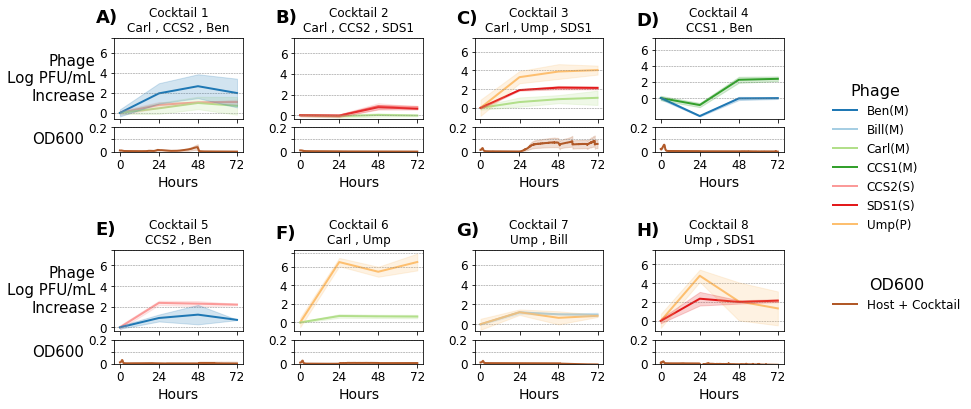

In [25]:
RIBBON_ALPHA=0.2
SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS = 1

phage_color_dict= {"Ben(M)":'#1f78b4',
                  "Bill(M)":'#a6cee3',
                  "Carl(M)":'#b2df8a',
                  "CCS1(M)":'#33a02c',
                  "CCS2(S)":'#fb9a99',
                  "SDS1(S)":'#e31a1c',
                  "Ump(P)":'#fdbf6f'}
od_color_dict={"Host Control":"#6a3d9a",
              "Host + Cocktail":"#b15928"}
od_color_dict={"Host + Cocktail":"#b15928"}

fig,axs =  plt.subplots(5,4,
                        figsize=(12,6),
                       gridspec_kw={'height_ratios': [1, .3,SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS, 1, .3]})

fig.subplots_adjust(wspace=.4, hspace=.15)
for j in [0,1,2,3]:
    axs[2,j].set_visible(False)

cocktail_list = ["Cocktail " + str(j) for j in range(1,9)]

for i, cocktail in enumerate(cocktail_list):
    j=0
    if i > 3:
        i-=4
        j+=3
    #Subset data
    od_dat_ss = od_plot_dat.query('Cocktail == @cocktail')
    qpcr_dat_ss = qpcr_plot_dat.query('Cocktail == @cocktail')
    
    #Get x values
    od_x = od_dat_ss.Hour.values
    
    #Get y values for qpcr
    phage_y_values = {}
    phage_y_errp = {}
    phage_y_errn = {}
    phage_x = {}
    for phage in set(qpcr_dat_ss.phage_measured):
        #Subset data
        phage_ss = qpcr_dat_ss.query('phage_measured == @phage')
        #Get x values
        phage_x[phage] = phage_ss.timepoint.values
        #Get y values
        phage_y_values[phage] = phage_ss.value.values
        #Get y error
        phage_y_errp[phage] = phage_ss.errp.values
        phage_y_errn[phage] = phage_ss.errn.values
        #Get colors
        color_ = phage_color_dict[phage]
        
        #Plot error
        axs[j,i].fill_between(phage_x[phage], phage_y_errn[phage], phage_y_errp[phage], 
                              color= color_, alpha=RIBBON_ALPHA, zorder=2)
        
        #Plot line
        axs[j,i].plot(phage_x[phage],phage_y_values[phage], 
                      color=color_, zorder=1, linewidth=2)
        
        
    
    #Get y values for OD
    od_control_y = od_dat_ss.host_avg.values
    od_cocktail_y = od_dat_ss.value_avg.values
    #Get errors for OD
    od_control_y_sem = od_dat_ss.host_sem.values
    od_cocktail_y_sem = od_dat_ss.value_sem.values
    
    #Plot OD line
    #axs[j+1,i].plot(od_x, od_control_y,  color=od_color_dict["Host Control"], linewidth=2)
    axs[j+1,i].plot(od_x, od_cocktail_y, color=od_color_dict["Host + Cocktail"], linewidth=2)
    
    #Plor OD error
    #axs[j+1,i].fill_between(od_x, od_control_y - od_control_y_sem, od_control_y + od_control_y_sem, 
    #                        color=od_color_dict["Host Control"], alpha=RIBBON_ALPHA)
    axs[j+1,i].fill_between(od_x, od_cocktail_y - od_cocktail_y_sem, od_cocktail_y + od_cocktail_y_sem,
                            color=od_color_dict["Host + Cocktail"], alpha=RIBBON_ALPHA)
    
    #Qpcr title
    title_text = qpcr_dat_ss.Cocktail.values[0] + "\n" +  qpcr_dat_ss.formatted_cocktail_name.values[0]        
    axs[j,i].set_title(title_text)
    #axis grid
    axs[j,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    axs[j+1,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    
    #Add stats
    #stat_df = anova_df_sig.query('Cocktail==@cocktail')
    #if stat_df.shape[0] != 0:
    #    axs[j,i].scatter(stat_df.Hour, [7] * stat_df.shape[0] , marker="*", color="black")
    
#Adjust qpcr plot
for j in [0,3]:
    for i in [0,1,2,3]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].set_yticks( [0,2,4,6,7.5] )
        axs[j,i].set_yticklabels( [0,2,4,6] )
        axs[j,i].set_xticklabels( [] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        if i==0:
            axs[j,i].set_ylabel('Phage\nLog PFU/mL\nIncrease', size=15, rotation=0,
                                verticalalignment="center",horizontalalignment="right" )


#Adjust OD plot
for j in [1,4]:
    for i in [0,1,2,3]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        axs[j,i].set_ylim([0,.2])
        axs[j,i].set_yticks([0,.1,.2])
        axs[j,i].set_yticklabels( [0,"",0.2] )
        #Set x axis labels
        axs[j,i].set_xlabel('Hours', size=14)
        if i==0:
            axs[j,i].set_ylabel('OD600', size=15, rotation=0,
                                verticalalignment="center", horizontalalignment="right")
            
#Phage legend
legend_lines = [plt.Line2D([0],[0], color=c, lw=2) for c in phage_color_dict.values()]
legend_labels = [x for x in phage_color_dict.keys()]
phage_legend = plt.legend(legend_lines, legend_labels,
                  bbox_to_anchor=(1.3, 12), loc='upper left', 
                          prop={'size': 12}, title="Phage", frameon=False)
plt.setp(phage_legend.get_title(),fontsize=16)

#OD Legend
legend_lines2 = [plt.Line2D([0],[0], color=c, lw=2) for c in od_color_dict.values()]
legend_labels2 = [x for x in od_color_dict.keys()]
OD_legend = plt.legend(legend_lines2, legend_labels2,
                  bbox_to_anchor=(1.3, 4), loc='upper left', 
                          prop={'size': 12}, title="OD600", frameon=False)
plt.setp(OD_legend.get_title(),fontsize=16)
#Add back phage legend
plt.gca().add_artist(phage_legend)

alphabet = ["A)","B)","C)","D)","E)","F)","G)","H)"]
alphabet_positions = [(0,0),(0,1),(0,2),(0,3), (3,0),(3,1),(3,2),(3,3)]
for i in range(0,8):  
    axs[alphabet_positions[i]].text(x=-15, y=9, s=alphabet[i],size=18, fontweight="bold")
    
plt.savefig("figures/Qpcr_timecourse_fig_minus_tp0_stats_v2.png", bbox_inches='tight')

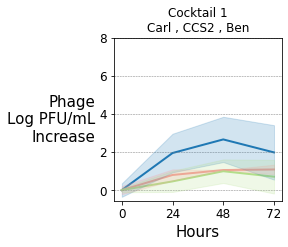

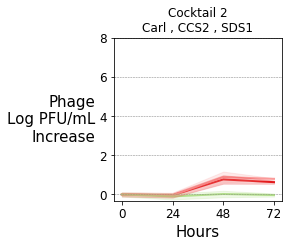

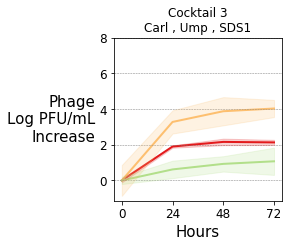

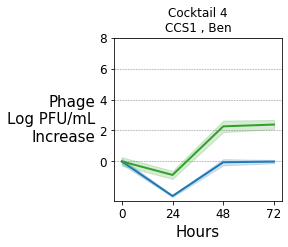

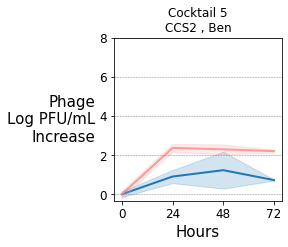

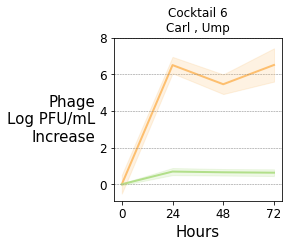

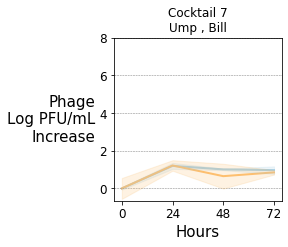

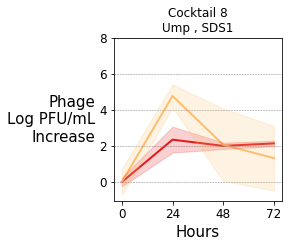

In [69]:
RIBBON_ALPHA=0.2
SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS = 1

phage_color_dict= {"Ben(M)":'#1f78b4',
                  "Bill(M)":'#a6cee3',
                  "Carl(M)":'#b2df8a',
                  "CCS1(M)":'#33a02c',
                  "CCS2(S)":'#fb9a99',
                  "SDS1(S)":'#e31a1c',
                  "Ump(P)":'#fdbf6f'}
od_color_dict={"Host Control":"#6a3d9a",
              "Host + Cocktail":"#b15928"}
od_color_dict={"Host + Cocktail":"#b15928"}



cocktail_list = ["Cocktail " + str(j) for j in range(1,9)]

for i, cocktail in enumerate(cocktail_list):
    
    fig,axs =  plt.subplots(1,
                        figsize=(3,3))
    #Subset data
    od_dat_ss = od_plot_dat.query('Cocktail == @cocktail')
    qpcr_dat_ss = qpcr_plot_dat.query('Cocktail == @cocktail')
    
    #Get x values
    od_x = od_dat_ss.Hour.values
    
    #Get y values for qpcr
    phage_y_values = {}
    phage_y_errp = {}
    phage_y_errn = {}
    phage_x = {}
    for phage in set(qpcr_dat_ss.phage_measured):
        #Subset data
        phage_ss = qpcr_dat_ss.query('phage_measured == @phage')
        #Get x values
        phage_x[phage] = phage_ss.timepoint.values
        #Get y values
        phage_y_values[phage] = phage_ss.value.values
        #Get y error
        phage_y_errp[phage] = phage_ss.errp.values
        phage_y_errn[phage] = phage_ss.errn.values
        #Get colors
        color_ = phage_color_dict[phage]
        
        #Plot error
        axs.fill_between(phage_x[phage], phage_y_errn[phage], phage_y_errp[phage], 
                              color= color_, alpha=RIBBON_ALPHA, zorder=2)
        
        #Plot line
        axs.plot(phage_x[phage],phage_y_values[phage], 
                      color=color_, zorder=1, linewidth=2)
        

    #Qpcr title
    title_text = qpcr_dat_ss.Cocktail.values[0] + "\n" +  qpcr_dat_ss.formatted_cocktail_name.values[0]        
    axs.set_title(title_text)
    #axis grid
    axs.grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    axs.grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    
    
    #Adjust qpcr plot
    axs.set_xticks( [0,24,48,72] )
    axs.set_yticks( [0,2,4,6,8] )
    axs.set_yticklabels( [0,2,4,6, 8] )
    axs.set_xticklabels( [0,24,48,72] )
    axs.tick_params(axis = 'both', which = 'major', labelsize = 12)
    axs.set_ylabel('Phage\nLog PFU/mL\nIncrease', size=15, rotation=0,
                        verticalalignment="center",horizontalalignment="right" )
    axs.set_xlabel("Hours", size=15)

    plt.savefig(f"figures/individual_qpcr_cocktails/cocktail_{str(i)}.png", bbox_inches='tight')
    plt.show()
    

___

In [54]:
!ls data/Pride_qpcr/

'Cocktail 1_(Carl+Ben+CCS2).xlsx'    OD_formatted.xlsx
'Cocktail 2_(Carl+SDS1+CCS2).xlsx'  'Single phage_OD data.xlsx'
'Cocktail 3_(Carl+SDS1+Ump).xlsx'   'Single phage_qPCR data.xlsx'
'Cocktail 4_(Ben+CCS1).xlsx'	     Single_phage_OD_formatted.txt
'Cocktail 5_(Ben+CCS2).xlsx'	     Single_phage_qpcr_formatted.txt
'Cocktail 6_(Carl+Ump)xlsx.xlsx'    '~$Cocktail 8_(SDS1+Ump).xlsx'
'Cocktail 7_( Bill+Ump).xlsx'	    '~$OD_formatted.xlsx'
'Cocktail 8_(SDS1+Ump).xlsx'	    '~$Single phage_OD data.xlsx'
'OD values_GC Exp.xlsx'


# Single phage qPCR

In [9]:
single_qpcr = pd.read_table('data/Pride_qpcr/Single_phage_qpcr_formatted.txt')
single_od = pd.read_table('data/Pride_qpcr/Single_phage_OD_formatted.txt')

#Split out positive and negative controls
single_od_pos = single_od.query('Phage == "No Phage"').copy()
single_od_neg = single_od.query('Phage == "Blank"').copy()
single_od_dat = single_od.query('Phage not in  ["Blank","No Phage"]').copy()

phage_color_dict= {"Ben(M)":'#1f78b4',
                  "Bill(M)":'#a6cee3',
                  "Carl(M)":'#b2df8a',
                  "CCS1(M)":'#33a02c',
                  "CCS2(S)":'#fb9a99',
                  "SDS1(S)":'#e31a1c',
                  "Ump(P)":'#fdbf6f'}
od_color_dict={"Host Control":"#6a3d9a",
              "Host + Cocktail":"#b15928"}

phage_type_dict = {"Bop":"M",
                 "Car":"M",
                 "CCS1":"M",
                 "CCS2":"S",
                 "CCS3":"S",
                 "Ump":"P",
                 "Carl":"M",
                 "Bill":"M",
                 "Ben":"M",
                 "SDS1":"S",
                 "SDS2":"S",
                 "PG2":"S",
                 "PG9":"S",
                 "PG11":"S",
                 "PG13":"S",
                 "V12":"M"}
phage_order = ["V12","Bop","Ben","Bill","Car","Carl","CCS1","SDS1","SDS2","CCS2","CCS3","PG2","PG9","PG11","PG13","Ump"]
phage_subtype = {x:"{}({})".format(x,phage_type_dict[x]) for x in phage_order}

# Format phage name
single_od_dat["Phage"] = [phage_subtype[x] for x in single_od_dat.Phage]
single_qpcr["Phage"] = [phage_subtype[x] for x in single_qpcr.phage_measured]
single_qpcr["timepoint"] = [int(x[:-1]) for x in single_qpcr.timepoint]
#subtract blank
single_od_dat["rep1"] = single_od_dat.rep1 -.13
single_od_dat["rep2"] = single_od_dat.rep2 -.13
single_od_dat["rep3"] = single_od_dat.rep3 -.13

#Get mean and SD
single_od_dat["avg"] = single_od_dat.apply(axis=1, func= lambda row: (row.rep1 + row.rep2 + row.rep3)/3)
single_od_dat["SEM"] = single_od_dat.apply(axis=1, func= lambda row: sem([row.rep1,row.rep2,row.rep3]))




Subtract nohost

In [10]:
nohost_dat = single_qpcr.query('condition=="no host"').copy()
#Get average
nohost_dat["avg"] = nohost_dat.apply(axis=1, func= lambda row: (row.value1 + row.value2 + row.value3)/3)
nohost_dat["SEM"] = nohost_dat.apply(axis=1, func= lambda row: sem([row.value1,row.value2,row.value3]))

all_phages =  set(single_qpcr.Phage)
all_tps = [0,24,48,72]
single_host_subtraction_dict = {}
for phage in all_phages:
    single_host_subtraction_dict[phage] = {}
    for tp in all_tps:
        dat_tmp = nohost_dat.query('Phage ==@phage and timepoint==@tp').avg.values[0]
        single_host_subtraction_dict[phage][tp] = dat_tmp

single_qpcr_dat = single_qpcr.query('condition=="with host"').copy()
single_qpcr_dat['value1_minushost'] = single_qpcr_dat.apply(axis=1, func = lambda row: row.value1 - single_host_subtraction_dict[row.Phage][row.timepoint])

In [11]:
single_qpcr_dat = single_qpcr.query('condition=="with host"').copy()
single_qpcr_dat['value1_minushost'] = single_qpcr_dat.apply(axis=1, func = lambda row: row.value1 - single_host_subtraction_dict[row.Phage][row.timepoint])
single_qpcr_dat['value2_minushost'] = single_qpcr_dat.apply(axis=1, func = lambda row: row.value2 - single_host_subtraction_dict[row.Phage][row.timepoint])
single_qpcr_dat['value3_minushost'] = single_qpcr_dat.apply(axis=1, func = lambda row: row.value3 - single_host_subtraction_dict[row.Phage][row.timepoint])

single_qpcr_dat["avg"] = single_qpcr_dat.apply(axis=1, func= lambda row: (row.value1_minushost + row.value2_minushost + row.value3_minushost)/3)
single_qpcr_dat["SEM"] = single_qpcr_dat.apply(axis=1, func= lambda row: sem([row.value1_minushost,row.value2_minushost,row.value3_minushost]))

In [17]:
single_qpcr_dat.head()

,host,cocktail,condition,phage_measured,timepoint,value1,value2,value3,Phage,value1_minushost,value2_minushost,value3_minushost,avg,SEM
0,YI6,Yi6-1 Single Phage Bill,with host,Bill,0,4.169624,3.970613,4.054413,Bill(M),-0.040390,-0.239401,-0.155601,-0.145131,0.057687
1,YI6,Yi6-1 Single Phage Bill,with host,Bill,24,8.964637,8.760139,8.741381,Bill(M),4.940443,4.735944,4.717187,4.797858,0.071498
2,YI6,Yi6-1 Single Phage Bill,with host,Bill,48,8.882283,8.665755,8.793517,Bill(M),4.761327,4.544799,4.672562,4.659563,0.062843
3,YI6,Yi6-1 Single Phage Bill,with host,Bill,72,9.055320,8.749960,8.392333,Bill(M),4.876502,4.571142,4.213515,4.553720,0.191586
8,YI7,Yi6-1 Single Phage Carl,with host,Carl,0,4.800863,4.882147,5.586234,Carl(M),-0.323657,-0.242373,0.461714,-0.034772,0.249350


Text(-15, 8, 'I)')

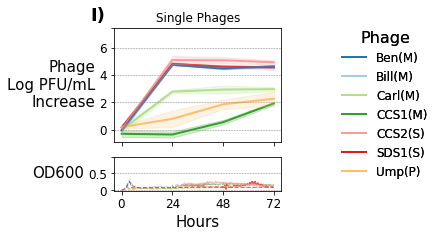

In [18]:
RIBBON_ALPHA=0.2
SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS = 1

phage_color_dict= {"Ben(M)":'#1f78b4',
                  "Bill(M)":'#a6cee3',
                  "Carl(M)":'#b2df8a',
                  "CCS1(M)":'#33a02c',
                  "CCS2(S)":'#fb9a99',
                  "SDS1(S)":'#e31a1c',
                  "Ump(P)":'#fdbf6f'}
od_color_dict={"Host Control":"#6a3d9a",
              "Host + Cocktail":"#b15928"}

fig,axs =  plt.subplots(2,1, figsize=(3,3),  gridspec_kw={'height_ratios': [1, .3]})

for phage in set(single_qpcr_dat.Phage):
    #Get colors
    color_ = phage_color_dict[phage]
    #Get single phage data
    single_phage_tmp = single_qpcr_dat.query('Phage == @phage')
    single_phage_tmp_y = single_phage_tmp.avg.values
    single_phage_tmp_x = single_phage_tmp.timepoint.values
    axs[0].plot(single_phage_tmp_x,single_phage_tmp_y, 
                  color=color_, zorder=1, linewidth=2)
    single_phage_tmp_x_perr = single_phage_tmp.avg + single_phage_tmp.SEM
    single_phage_tmp_x_nerr = single_phage_tmp.avg - single_phage_tmp.SEM
    axs[0].fill_between(single_phage_tmp_x, single_phage_tmp_x_nerr, single_phage_tmp_x_perr, 
                              color= color_, alpha=RIBBON_ALPHA, zorder=2)
    #Qpcr title
    single_phage_od_y = single_od_dat.query('Phage==@phage').avg
    single_phage_od_x = single_od_dat.query('Phage==@phage').Hour
    axs[1].plot(single_phage_od_x, single_phage_od_y,  color=color_, linewidth=1, linestyle='dashed', dashes=(4, 2), alpha=.7)
title_text = "Single Phages"    
axs[0].set_title(title_text)
    #axis grid
axs[0].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
axs[1].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')

    
#Adjust qpcr plot
axs[0].set_xticks( [0,24,48,72] )
axs[1].set_xticks( [0,24,48,72] )
axs[0].set_yticks( [0,2,4,6,7.5] )
axs[0].set_yticklabels( [0,2,4,6] )
axs[1].set_yticks( [0,.5,1] )
axs[1].set_yticklabels( [0,.5] )
axs[1].set_xticklabels( [0,24,48,72] )
axs[0].set_xticklabels( [] )
axs[0].tick_params(axis = 'both', which = 'major', labelsize = 12)
axs[1].tick_params(axis = 'both', which = 'major', labelsize = 12)
axs[0].set_ylabel('Phage\nLog PFU/mL\nIncrease', size=15, rotation=0,
                        verticalalignment="center",horizontalalignment="right" )
axs[1].set_xlabel("Hours", size=15)
axs[1].set_ylabel('OD600', size=15, rotation=0,
                                verticalalignment="center", horizontalalignment="right")           
    
#Phage legend
legend_lines = [plt.Line2D([0],[0], color=c, lw=2) for c in phage_color_dict.values()]
legend_labels = [x for x in phage_color_dict.keys()]
phage_legend = plt.legend(legend_lines, legend_labels,
                  bbox_to_anchor=(1.3, 5), loc='upper left', 
                          prop={'size': 12}, title="Phage", frameon=False)
plt.setp(phage_legend.get_title(),fontsize=16)

#OD Legend
legend_lines2 = [plt.Line2D([0],[0], color=c, lw=2) for c in od_color_dict.values()]

#Add back phage legend
plt.gca().add_artist(phage_legend)

axs[0].text(x=-15, y=8, s="I)",size=18, fontweight="bold")
    
#plt.savefig("figures/Qpcr_timecourse_single_phage.png", bbox_inches='tight')

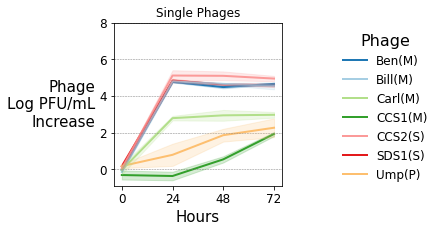

In [30]:
RIBBON_ALPHA=0.2
SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS = 1

phage_color_dict= {"Ben(M)":'#1f78b4',
                  "Bill(M)":'#a6cee3',
                  "Carl(M)":'#b2df8a',
                  "CCS1(M)":'#33a02c',
                  "CCS2(S)":'#fb9a99',
                  "SDS1(S)":'#e31a1c',
                  "Ump(P)":'#fdbf6f'}
od_color_dict={"Host Control":"#6a3d9a",
              "Host + Cocktail":"#b15928"}

fig,axs =  plt.subplots(1, figsize=(3,3))

for phage in set(single_qpcr_dat.Phage):
    #Get colors
    color_ = phage_color_dict[phage]
    #Get single phage data
    single_phage_tmp = single_qpcr_dat.query('Phage == @phage')
    single_phage_tmp_y = single_phage_tmp.avg.values
    single_phage_tmp_x = single_phage_tmp.timepoint.values
    axs.plot(single_phage_tmp_x,single_phage_tmp_y, 
                  color=color_, zorder=1, linewidth=2)
    single_phage_tmp_x_perr = single_phage_tmp.avg + single_phage_tmp.SEM
    single_phage_tmp_x_nerr = single_phage_tmp.avg - single_phage_tmp.SEM
    axs.fill_between(single_phage_tmp_x, single_phage_tmp_x_nerr, single_phage_tmp_x_perr, 
                              color= color_, alpha=RIBBON_ALPHA, zorder=2)

title_text = "Single Phages"    
axs.set_title(title_text)
    #axis grid
axs.grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
axs.grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')

    
#Adjust qpcr plot
axs.set_xticks( [0,24,48,72] )

axs.set_yticks( [0,2,4,6,8] )
axs.set_yticklabels( [0,2,4,6,8] )

axs.set_xticklabels(  [0,24,48,72] )
axs.tick_params(axis = 'both', which = 'major', labelsize = 12)
axs.set_ylabel('Phage\nLog PFU/mL\nIncrease', size=15, rotation=0,
                        verticalalignment="center",horizontalalignment="right" )
axs.set_xlabel('Hours', size=15)        
    
#Phage legend
legend_lines = [plt.Line2D([0],[0], color=c, lw=2) for c in phage_color_dict.values()]
legend_labels = [x for x in phage_color_dict.keys()]
phage_legend = plt.legend(legend_lines, legend_labels,
                  bbox_to_anchor=(1.3, 1), loc='upper left', 
                          prop={'size': 12}, title="Phage", frameon=False)
plt.setp(phage_legend.get_title(),fontsize=16)
    
plt.savefig("figures/individual_qpcr_cocktails/single_phages.png", bbox_inches='tight')

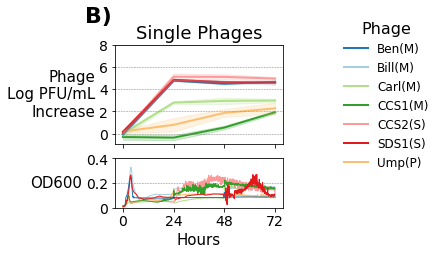

In [179]:
RIBBON_ALPHA=0.2
SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS = 1

phage_color_dict= {"Ben(M)":'#1f78b4',
                  "Bill(M)":'#a6cee3',
                  "Carl(M)":'#b2df8a',
                  "CCS1(M)":'#33a02c',
                  "CCS2(S)":'#fb9a99',
                  "SDS1(S)":'#e31a1c',
                  "Ump(P)":'#fdbf6f'}
od_color_dict={"Host Control":"#6a3d9a",
              "Host + Cocktail":"#b15928"}

fig,axs =  plt.subplots(2,1, figsize=(3,3),  gridspec_kw={'height_ratios': [1, .5]})

for phage in set(single_qpcr_dat.Phage):
    #Get colors
    color_ = phage_color_dict[phage]
    #Get single phage data
    single_phage_tmp = single_qpcr_dat.query('Phage == @phage')
    single_phage_tmp_y = single_phage_tmp.avg.values
    single_phage_tmp_x = single_phage_tmp.timepoint.values
    axs[0].plot(single_phage_tmp_x,single_phage_tmp_y, 
                  color=color_, zorder=1, linewidth=2)
    single_phage_tmp_x_perr = single_phage_tmp.avg + single_phage_tmp.SEM
    single_phage_tmp_x_nerr = single_phage_tmp.avg - single_phage_tmp.SEM
    axs[0].fill_between(single_phage_tmp_x, single_phage_tmp_x_nerr, single_phage_tmp_x_perr, 
                              color= color_, alpha=RIBBON_ALPHA, zorder=2)
    #Qpcr title
    single_phage_od_y = single_od_dat.query('Phage==@phage').avg
    single_phage_od_x = single_od_dat.query('Phage==@phage').Hour
    axs[1].plot(single_phage_od_x, single_phage_od_y,  color=color_, linewidth=1)
title_text = "Single Phages"    
axs[0].set_title(title_text, size=18)
    #axis grid
axs[0].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
axs[1].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')

    
#Adjust qpcr plot
axs[0].set_xticks( [0,24,48,72] )
axs[1].set_xticks( [0,24,48,72] )
axs[0].set_yticks( [0,2,4,6,8] )
axs[0].set_yticklabels( [0,2,4,6,8] )
axs[1].set_yticks([0,.2,.4])
axs[1].set_yticklabels( [0,0.2,.4] )
axs[1].set_ylim( [0,.4] )
axs[1].set_xticklabels( [0,24,48,72] )
axs[0].set_xticklabels( [] )
axs[0].tick_params(axis = 'both', which = 'major', labelsize = 14)
axs[1].tick_params(axis = 'both', which = 'major', labelsize = 14)
axs[0].set_ylabel('Phage\nLog PFU/mL\nIncrease', size=15, rotation=0,
                        verticalalignment="center",horizontalalignment="right" )
axs[1].set_xlabel("Hours", size=15)
axs[1].set_ylabel('OD600', size=15, rotation=0,
                                verticalalignment="center", horizontalalignment="right")           
    
#Phage legend
legend_lines = [plt.Line2D([0],[0], color=c, lw=2) for c in phage_color_dict.values()]
legend_labels = [x for x in phage_color_dict.keys()]
phage_legend = plt.legend(legend_lines, legend_labels,
                  bbox_to_anchor=(1.3, 4), loc='upper left', 
                          prop={'size': 12}, title="Phage", frameon=False)
plt.setp(phage_legend.get_title(),fontsize=16)

#OD Legend
legend_lines2 = [plt.Line2D([0],[0], color=c, lw=2) for c in od_color_dict.values()]

#Add back phage legend
#plt.gca().add_artist(phage_legend)

axs[0].text(x=-18, y=10, s="B)",size=22, fontweight="bold")
    
plt.savefig("figures/Qpcr_timecourse_single_phage.png", bbox_inches='tight')

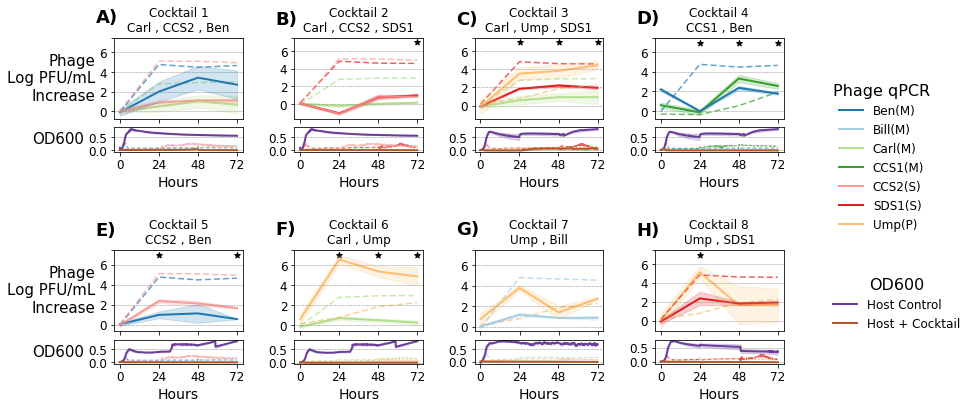

In [110]:
RIBBON_ALPHA=0.2
SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS = 1

phage_color_dict= {"Ben(M)":'#1f78b4',
                  "Bill(M)":'#a6cee3',
                  "Carl(M)":'#b2df8a',
                  "CCS1(M)":'#33a02c',
                  "CCS2(S)":'#fb9a99',
                  "SDS1(S)":'#e31a1c',
                  "Ump(P)":'#fdbf6f'}
od_color_dict={"Host Control":"#6a3d9a",
              "Host + Cocktail":"#b15928"}

fig,axs =  plt.subplots(5,4,
                        figsize=(12,6),
                       gridspec_kw={'height_ratios': [1, .3,SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS, 1, .3]})

fig.subplots_adjust(wspace=.4, hspace=.15)
for j in [0,1,2,3]:
    axs[2,j].set_visible(False)

cocktail_list = ["Cocktail " + str(j) for j in range(1,9)]

for i, cocktail in enumerate(cocktail_list):
    j=0
    if i > 3:
        i-=4
        j+=3
    #Subset data
    od_dat_ss = od_plot_dat.query('Cocktail == @cocktail')
    qpcr_dat_ss = qpcr_plot_dat_minus_nohost.query('Cocktail == @cocktail')
    
    #Get x values
    od_x = od_dat_ss.Hour.values
    
    #Get y values for qpcr
    phage_y_values = {}
    phage_y_errp = {}
    phage_y_errn = {}
    phage_x = {}
    for phage in set(qpcr_dat_ss.phage_measured):
        #Subset data
        phage_ss = qpcr_dat_ss.query('phage_measured == @phage')
        #Get x values
        phage_x[phage] = phage_ss.timepoint.values
        #Get y values
        phage_y_values[phage] = phage_ss.value.values
        #Get y error
        phage_y_errp[phage] = phage_ss.errp.values
        phage_y_errn[phage] = phage_ss.errn.values
        #Get colors
        color_ = phage_color_dict[phage]
        
        #Plot error
        axs[j,i].fill_between(phage_x[phage], phage_y_errn[phage], phage_y_errp[phage], 
                              color= color_, alpha=RIBBON_ALPHA, zorder=2)
        
        #Plot line
        axs[j,i].plot(phage_x[phage],phage_y_values[phage], 
                      color=color_, zorder=1, linewidth=2)
        
        #Get single phage data
        single_phage_tmp = single_qpcr_dat.query('Phage == @phage')
        single_phage_tmp_y = single_phage_tmp.avg
        axs[j,i].plot(phage_x[phage],single_phage_tmp_y, 
                      color=color_, zorder=1, linewidth=1.5, linestyle='dashed', dashes=(4, 2), alpha=.7)
        
        #Plot single phage OD line
        single_phage_od_y = single_od_dat.query('Phage==@phage').avg
        single_phage_od_x = single_od_dat.query('Phage==@phage').Hour
        axs[j+1,i].plot(single_phage_od_x, single_phage_od_y,  color=color_, linewidth=1, linestyle='dashed', dashes=(4, 2), alpha=.7)
        
        
    
    #Get y values for OD
    od_control_y = od_dat_ss.host_avg.values
    od_cocktail_y = od_dat_ss.value_avg.values
    #Get errors for OD
    od_control_y_sem = od_dat_ss.host_sem.values
    od_cocktail_y_sem = od_dat_ss.value_sem.values
    
    #Plot OD line
    axs[j+1,i].plot(od_x, od_control_y,  color=od_color_dict["Host Control"], linewidth=2)
    axs[j+1,i].plot(od_x, od_cocktail_y, color=od_color_dict["Host + Cocktail"], linewidth=2)
    
    #Plor OD error
    axs[j+1,i].fill_between(od_x, od_control_y - od_control_y_sem, od_control_y + od_control_y_sem, 
                            color=od_color_dict["Host Control"], alpha=RIBBON_ALPHA)
    axs[j+1,i].fill_between(od_x, od_cocktail_y - od_cocktail_y_sem, od_cocktail_y + od_cocktail_y_sem,
                            color=od_color_dict["Host + Cocktail"], alpha=RIBBON_ALPHA)
    
    #Qpcr title
    title_text = qpcr_dat_ss.Cocktail.values[0] + "\n" +  qpcr_dat_ss.formatted_cocktail_name.values[0]        
    axs[j,i].set_title(title_text)
    #axis grid
    axs[j,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    axs[j+1,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    
    #Add stats
    stat_df = anova_df_sig.query('Cocktail==@cocktail')
    if stat_df.shape[0] != 0:
        axs[j,i].scatter(stat_df.Hour, [7] * stat_df.shape[0] , marker="*", color="black")
    
#Adjust qpcr plot
for j in [0,3]:
    for i in [0,1,2,3]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].set_yticks( [0,2,4,6,7.5] )
        axs[j,i].set_yticklabels( [0,2,4,6] )
        axs[j,i].set_xticklabels( [] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        if i==0:
            axs[j,i].set_ylabel('Phage\nLog PFU/mL\nIncrease', size=15, rotation=0,
                                verticalalignment="center",horizontalalignment="right" )


#Adjust OD plot
for j in [1,4]:
    for i in [0,1,2,3]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        #Set x axis labels
        axs[j,i].set_xlabel('Hours', size=14)
        if i==0:
            axs[j,i].set_ylabel('OD600', size=15, rotation=0,
                                verticalalignment="center", horizontalalignment="right")
            
#Phage legend
legend_lines = [plt.Line2D([0],[0], color=c, lw=2) for c in phage_color_dict.values()]
legend_labels = [x for x in phage_color_dict.keys()]
phage_legend = plt.legend(legend_lines, legend_labels,
                  bbox_to_anchor=(1.3, 12), loc='upper left', 
                          prop={'size': 12}, title="Phage qPCR", frameon=False)
plt.setp(phage_legend.get_title(),fontsize=16)

#OD Legend
legend_lines2 = [plt.Line2D([0],[0], color=c, lw=2) for c in od_color_dict.values()]

legend_labels2 = [x for x in od_color_dict.keys()]

OD_legend = plt.legend(legend_lines2, legend_labels2,
                  bbox_to_anchor=(1.3, 4), loc='upper left', 
                          prop={'size': 12}, title="OD600", frameon=False)
plt.setp(OD_legend.get_title(),fontsize=16)

#Legend3
'''
legend_lines3 = [plt.Line2D([0],[0], color="black", lw=2), plt.Line2D([0],[0], color="black", lw=1.5, linestyle="dashed")]
legend_labels3 = ["Phage Cocktail", 'Single Phage']
legend_3 = plt.legend(legend_lines3, legend_labels3,
                  bbox_to_anchor=(1.3, 14), loc='upper left', 
                          prop={'size': 12}, title="Cocktail vs Single Phage", frameon=False)
plt.setp(legend_3.get_title(),fontsize=16)
'''
#Add back phage legend
plt.gca().add_artist(phage_legend)

alphabet = ["A)","B)","C)","D)","E)","F)","G)","H)"]
alphabet_positions = [(0,0),(0,1),(0,2),(0,3), (3,0),(3,1),(3,2),(3,3)]
for i in range(0,8):  
    axs[alphabet_positions[i]].text(x=-15, y=9, s=alphabet[i],size=18, fontweight="bold")
    
#plt.savefig("figures/Qpcr_timecourse_fig_minus_nohost_stats.png", bbox_inches='tight')

# Plot growth curves

In [68]:
single_qpcr = pd.read_table('data/Pride_qpcr/Single_phage_qpcr_formatted.txt')
single_od = pd.read_table('data/Pride_qpcr/Single_phage_OD_formatted.txt')

#Split out positive and negative controls
single_od_pos = single_od.query('Phage == "No Phage"').copy()
single_od_neg = single_od.query('Phage == "Blank"').copy()
single_od_dat = single_od.query('Phage not in  ["Blank","No Phage"]').copy()

phage_color_dict= {"Ben(M)":'#1f78b4',
                  "Bill(M)":'#a6cee3',
                  "Carl(M)":'#b2df8a',
                  "CCS1(M)":'#33a02c',
                  "CCS2(S)":'#fb9a99',
                  "SDS1(S)":'#e31a1c',
                  "Ump(P)":'#fdbf6f'}
od_color_dict={"Host Control":"#6a3d9a",
              "Host + Cocktail":"#b15928"}

phage_type_dict = {"Bop":"M",
                 "Car":"M",
                 "CCS1":"M",
                 "CCS2":"S",
                 "CCS3":"S",
                 "Ump":"P",
                 "Carl":"M",
                 "Bill":"M",
                 "Ben":"M",
                 "SDS1":"S",
                 "SDS2":"S",
                 "PG2":"S",
                 "PG9":"S",
                 "PG11":"S",
                 "PG13":"S",
                 "V12":"M"}
phage_order = ["V12","Bop","Ben","Bill","Car","Carl","CCS1","SDS1","SDS2","CCS2","CCS3","PG2","PG9","PG11","PG13","Ump"]
phage_subtype = {x:"{}({})".format(x,phage_type_dict[x]) for x in phage_order}

# Format phage name
single_od_dat["Phage"] = [phage_subtype[x] for x in single_od_dat.Phage]
single_qpcr["Phage"] = [phage_subtype[x] for x in single_qpcr.phage_measured]
single_qpcr["timepoint"] = [int(x[:-1]) for x in single_qpcr.timepoint]
#subtract blank
single_od_dat["rep1"] = single_od_dat.rep1 -.13
single_od_dat["rep2"] = single_od_dat.rep2 -.13
single_od_dat["rep3"] = single_od_dat.rep3 -.13

#Get mean and SD
single_od_dat["avg"] = single_od_dat.apply(axis=1, func= lambda row: (row.rep1 + row.rep2 + row.rep3)/3)
single_od_dat["SEM"] = single_od_dat.apply(axis=1, func= lambda row: sem([row.rep1,row.rep2,row.rep3]))




In [69]:
od_plot_dat.groupby("Cocktail").cocktail_long.value_counts()

Cocktail    cocktail_long             
Cocktail 1  Cocktail 1_(Carl+Ben+CCS2)    849
Cocktail 2  Cocktail 2_(Ben+SDS1+CCS2)    849
Cocktail 3  Cocktail 3_(Ben+SDS1+Ump)     849
Cocktail 4  Cocktail 4_(Ben+CCS1)         849
Cocktail 5  Cocktail 5_(Ben+CCS2)         849
Cocktail 6  Cocktail 6_(Carl+Ump)         849
Cocktail 7  Cocktail 7_(Bill+Ump)         849
Cocktail 8  Cocktail 8_(SDS1+Ump)         849
Name: cocktail_long, dtype: int64

In [70]:
host_data = od_plot_dat[["Cocktail","Hour","host_only1","host_only2","host_only3","cocktail_long"]].query('Cocktail == ["Cocktail 1","Cocktail 3","Cocktail 5","Cocktail 8"]')
host_data["control"] = True
host_data["n_phages"] = [3 if x in ["Cocktail 1","Cocktail 2", "Cocktail 3"] else 2 for x in host_data.Cocktail]
host_data = host_data.rename(columns = {"host_only1":"value1","host_only2":"value2", "host_only3":"value3"} )

In [71]:
cocktail_dat = od_plot_dat[["Cocktail","Hour","value1","value2","value3","cocktail_long"]].copy()
cocktail_dat["control"] = False
cocktail_dat["n_phages"] = [3 if x in ["Cocktail 1","Cocktail 2", "Cocktail 3"] else 2 for x in cocktail_dat["Cocktail"]]

In [72]:
od_dat = pd.concat([host_data,cocktail_dat])

In [73]:
od_dat["color_col"] = od_dat.apply(axis=1, func = lambda row: "Host only" if row.control else str(row.n_phages) + " Phages")

In [74]:
od_dat["avg"] = od_dat.apply(axis=1, func = lambda row: np.mean([row.value1,row.value2,row.value3]) )
od_dat["STD"] = od_dat.apply(axis=1, func = lambda row: np.std([row.value1,row.value2,row.value3]) )


In [75]:
plot_dat_1 = od_dat.melt(id_vars = ["Cocktail","Hour","control","cocktail_long","n_phages","color_col"], value_vars = ["value1","value2","value3"])\
    .groupby(["Hour",'color_col']).agg({"value":[np.mean,np.std]})

In [76]:
plot_dat_1 = plot_dat_1.reset_index()
plot_dat_1.columns = ["Hour","color_col","value","STD"]

In [77]:
one_phage_data = single_od_dat.groupby('Hour').agg({'avg':['mean',np.std]}).reset_index()
one_phage_data["color_col"] = "1 Phage"
one_phage_data.columns = ["Hour","value","STD","color_col"]
plot_dat_2 = pd.concat([plot_dat_1, one_phage_data])
plot_dat_2.head()

,Hour,color_col,value,STD
0,0.0833,2 Phages,0.012371,0.004657
1,0.0833,3 Phages,0.010602,0.002519
2,0.0833,Host only,0.032783,0.034513
3,0.1667,2 Phages,0.012631,0.004019
4,0.1667,3 Phages,0.010247,0.002514


/home/swandro/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 3 in image.
/home/swandro/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/OD_figs/one_two_three_phages.png


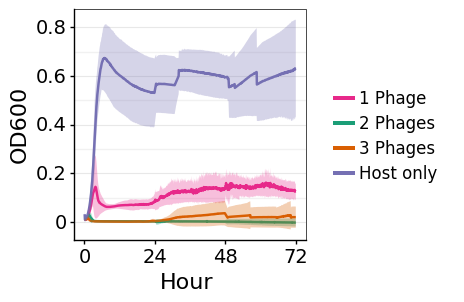

<ggplot: (8781917405648)>

In [128]:
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']

#colors = ["#ff7f00",'#1f78b4','#e31a1c','#33a02c']
colors = ['#e7298a','#1b9e77','#d95f02','#7570b3',]

pn.options.figure_size = 3,3
p  = (pn.ggplot( data = plot_dat_2) + 
      pn.geom_line( pn.aes(x="Hour", y ="value", color="color_col"), size=1) +
      pn.geom_ribbon( pn.aes(x="Hour", ymin ="value - STD", ymax = "value + STD", fill="color_col"), alpha=.3, color=None) +
      pn.scale_x_continuous(limits = [0,72], breaks = [0,24,48,72]) +
      pn.labs( x = "Hour", y= "OD600", color= "") +
      pn.scale_color_manual(colors) +
      pn.scale_fill_manual(colors) +
      pn.guides( fill=None) +
      pn.theme_classic() +
      pn.theme(
              panel_border = pn.element_rect(color="black", size=.5),
              panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.5),
              panel_grid_minor_y = pn.element_line(color="lightgrey", alpha=.3),
              axis_text = pn.element_text(size=14, color="black"),
              axis_title = pn.element_text(size=16, color="black"),
              legend_title = pn.element_text(size=14),
              legend_text = pn.element_text(size=12)
      )
     
     )      
pn.ggsave(p, "figures/OD_figs/one_two_three_phages.png")
p

/home/swandro/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 3 in image.
/home/swandro/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/OD_figs/1phage.png


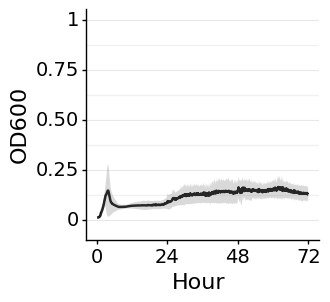

<ggplot: (8781922127668)>

In [80]:
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']

colors = ["#ff7f00",'#1f78b4','#e31a1c','#33a02c']

pn.options.figure_size = 3,3
p  = (pn.ggplot( data = plot_dat_2.query('color_col == "1 Phage"')) + 
      pn.geom_line( pn.aes(x="Hour", y ="value"), color="black", size=1) +
      pn.geom_ribbon( pn.aes(x="Hour", ymin ="value - STD", ymax = "value + STD"), fill="grey",alpha=.3, color=None) +
      pn.scale_x_continuous(limits = [0,72], breaks = [0,24,48,72]) +
      pn.scale_y_continuous(limits = [-.05,1]) +
      pn.labs( x = "Hour", y= "OD600", color= "Condition") +
      pn.scale_color_manual(colors) +
      pn.scale_fill_manual(colors) +
      pn.guides( fill=None) +
      pn.theme_classic() +
      pn.theme(
              panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.5),
              panel_grid_minor_y = pn.element_line(color="lightgrey", alpha=.3),
              axis_text = pn.element_text(size=14, color="black"),
              axis_title = pn.element_text(size=16, color="black"),
              legend_title = pn.element_text(size=16)
      )
     
     )      
pn.ggsave(p, "figures/OD_figs/1phage.png")
p

/home/swandro/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 3 in image.
/home/swandro/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/OD_figs/no_phage.png


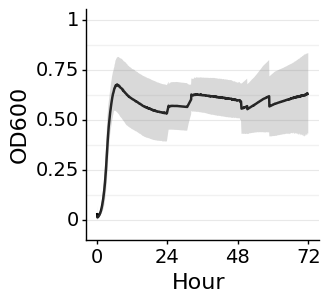

<ggplot: (8750731129019)>

In [66]:
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']

colors = ["#ff7f00",'#1f78b4','#e31a1c','#33a02c']

pn.options.figure_size = 3,3
p  = (pn.ggplot( data = plot_dat_2.query('color_col == "Host only"')) + 
      pn.geom_line( pn.aes(x="Hour", y ="value"), color="black", size=1) +
      pn.geom_ribbon( pn.aes(x="Hour", ymin ="value - STD", ymax = "value + STD"), fill="grey",alpha=.3, color=None) +
      pn.scale_x_continuous(limits = [0,72], breaks = [0,24,48,72]) +
      pn.scale_y_continuous(limits = [-.05,1]) +
      pn.labs( x = "Hour", y= "OD600", color= "Condition") +
      pn.scale_color_manual(colors) +
      pn.scale_fill_manual(colors) +
      pn.guides( fill=None) +
      pn.theme_classic() +
      pn.theme(
              panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.5),
              panel_grid_minor_y = pn.element_line(color="lightgrey", alpha=.3),
              axis_text = pn.element_text(size=14, color="black"),
              axis_title = pn.element_text(size=16, color="black"),
              legend_title = pn.element_text(size=16)
      )
     
     )      
pn.ggsave(p, "figures/OD_figs/no_phage.png")
p

/home/swandro/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 3 in image.
/home/swandro/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/OD_figs/3phage.png


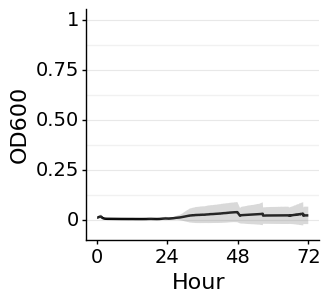

<ggplot: (8750730868547)>

In [64]:
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']

colors = ["#ff7f00",'#1f78b4','#e31a1c','#33a02c']

pn.options.figure_size = 3,3
p  = (pn.ggplot( data = plot_dat_2.query('color_col == "3 Phages"')) + 
      pn.geom_line( pn.aes(x="Hour", y ="value"), color="black", size=1) +
      pn.geom_ribbon( pn.aes(x="Hour", ymin ="value - STD", ymax = "value + STD"), fill="grey",alpha=.3, color=None) +
      pn.scale_x_continuous(limits = [0,72], breaks = [0,24,48,72]) +
      pn.scale_y_continuous(limits = [-.05,1]) +
      pn.labs( x = "Hour", y= "OD600", color= "Condition") +
      pn.scale_color_manual(colors) +
      pn.scale_fill_manual(colors) +
      pn.guides( fill=None) +
      pn.theme_classic() +
      pn.theme(
              panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.5),
              panel_grid_minor_y = pn.element_line(color="lightgrey", alpha=.3),
              axis_text = pn.element_text(size=14, color="black"),
              axis_title = pn.element_text(size=16, color="black"),
              legend_title = pn.element_text(size=16)
      )
     
     )      
pn.ggsave(p, "figures/OD_figs/3phage.png")
p

/home/swandro/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 3 in image.
/home/swandro/miniconda3/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/OD_figs/2phage.png


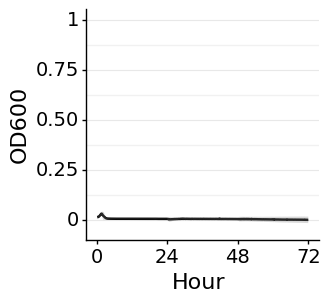

<ggplot: (8750731217637)>

In [65]:
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']

colors = ["#ff7f00",'#1f78b4','#e31a1c','#33a02c']

pn.options.figure_size = 3,3
p  = (pn.ggplot( data = plot_dat_2.query('color_col == "2 Phages"')) + 
      pn.geom_line( pn.aes(x="Hour", y ="value"), color="black", size=1) +
      pn.geom_ribbon( pn.aes(x="Hour", ymin ="value - STD", ymax = "value + STD"), fill="grey",alpha=.3, color=None) +
      pn.scale_x_continuous(limits = [0,72], breaks = [0,24,48,72]) +
      pn.scale_y_continuous(limits = [-.05,1]) +
      pn.labs( x = "Hour", y= "OD600", color= "Condition") +
      pn.scale_color_manual(colors) +
      pn.scale_fill_manual(colors) +
      pn.guides( fill=None) +
      pn.theme_classic() +
      pn.theme(
              panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.5),
              panel_grid_minor_y = pn.element_line(color="lightgrey", alpha=.3),
              axis_text = pn.element_text(size=14, color="black"),
              axis_title = pn.element_text(size=16, color="black"),
              legend_title = pn.element_text(size=16)
      )
     
     )      
pn.ggsave(p, "figures/OD_figs/2phage.png")
p

In [171]:
single_od_dat.Phage.value_counts()

Ben(M)     864
Carl(M)    864
Bill(M)    864
CCS1(M)    864
CCS2(S)    864
SDS1(S)    864
Ump(P)     864
Name: Phage, dtype: int64

In [187]:
one_phage_od_plot_dat = single_od_dat.copy()
phage_color_dict= {"Ben(M)":'#1f78b4',
                  "Bill(M)":'#a6cee3',
                  "Carl(M)":'#b2df8a',
                  "CCS1(M)":'#33a02c',
                  "CCS2(S)":'#fb9a99',
                  "SDS1(S)":'#e31a1c',
                  "Ump(P)":'#fdbf6f'}

one_phage_od_plot_dat["color"] = [phage_color_dict[x] for x in one_phage_od_plot_dat.Phage]
one_phage_od_plot_dat["avg"] = one_phage_od_plot_dat["avg"]

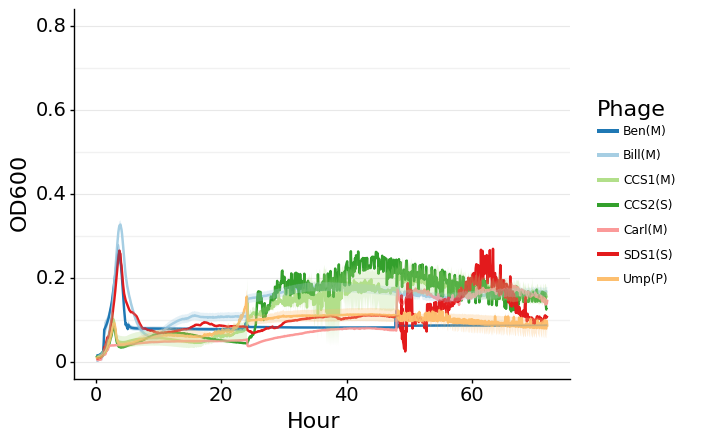

<ggplot: (8786022903842)>

In [192]:
#colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']

colors = list(phage_color_dict.values())


p  = (pn.ggplot( data = one_phage_od_plot_dat) + 
      pn.geom_line( pn.aes(x="Hour", y ="avg", color="Phage"), size=1) +
      pn.geom_ribbon( pn.aes(x="Hour", ymin ="avg - SEM", ymax = "avg + SEM", fill="Phage"), alpha=.3, color=None) +
      pn.labs( x = "Hour", y= "OD600", color= "Phage") +
      pn.scale_color_manual(colors) +
      pn.scale_fill_manual(colors) +
      pn.scale_y_continuous(limits = [0,.8]) +
      pn.guides( fill=None) +
      pn.theme_classic() +
      pn.theme(
              panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.5),
              panel_grid_minor_y = pn.element_line(color="lightgrey", alpha=.3),
              axis_text = pn.element_text(size=14, color="black"),
              axis_title = pn.element_text(size=16, color="black"),
          legend_title = pn.element_text(size=16)
      )
     
     )      
p

In [71]:
len(host_data.Hour.value_counts())

849

In [15]:
od_file.columns

Index(['index', 'Strain', 'Cocktail', 'Hour', 'value1', 'value2', 'value3',
       'phage_only1', 'phage_only2', 'phage_only3', 'host_only1', 'host_only2',
       'host_only3', 'negative1', 'negative2', 'negative3', 'value_avg',
       'phage_avg', 'host_avg', 'value_sd', 'phage_sd', 'host_sd', 'value_sem',
       'phage_sem', 'host_sem'],
      dtype='object')

# Plot 3 x 3 grid

In [28]:
1 % 3

1

In [41]:
int(3/3)

1

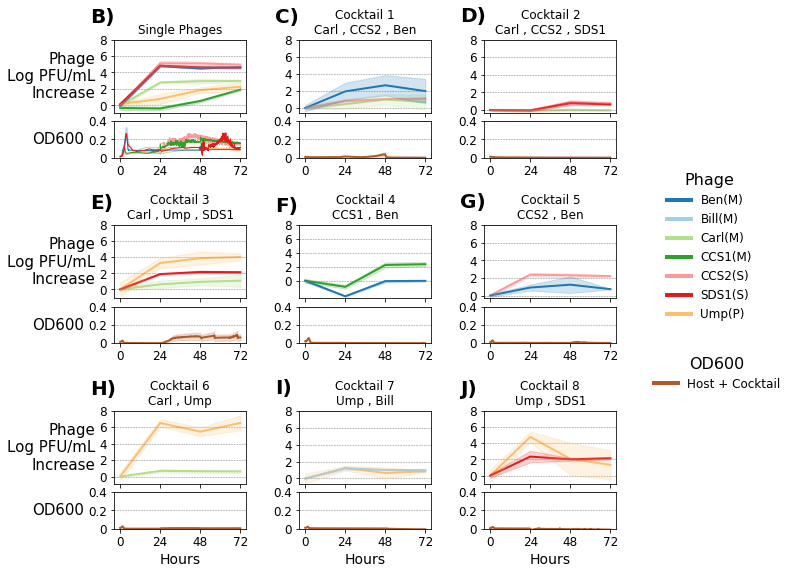

In [82]:
RIBBON_ALPHA=0.2
SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS = .7
qpcr_height = 1
od_height = .5

phage_color_dict= {"Ben(M)":'#1f78b4',
                  "Bill(M)":'#a6cee3',
                  "Carl(M)":'#b2df8a',
                  "CCS1(M)":'#33a02c',
                  "CCS2(S)":'#fb9a99',
                  "SDS1(S)":'#e31a1c',
                  "Ump(P)":'#fdbf6f'}
od_color_dict={"Host Control":"#6a3d9a",
              "Host + Cocktail":"#b15928"}
od_color_dict={"Host + Cocktail":"#b15928"}

fig,axs =  plt.subplots(8,3,
                        figsize=(9,9),
                       gridspec_kw={'height_ratios': [qpcr_height, od_height,SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS, qpcr_height, od_height, SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS, qpcr_height, od_height]})

fig.subplots_adjust(wspace=.4, hspace=.15)
for j in [0,1,2]:
    axs[2,j].set_visible(False)
    axs[5,j].set_visible(False)

cocktail_list = ["Cocktail " + str(j) for j in range(1,9)]

# Do Single phages
for phage in set(single_qpcr_dat.Phage):
    #Get colors
    color_ = phage_color_dict[phage]
    #Get single phage data
    single_phage_tmp = single_qpcr_dat.query('Phage == @phage')
    single_phage_tmp_y = single_phage_tmp.avg.values
    single_phage_tmp_x = single_phage_tmp.timepoint.values
    axs[0,0].plot(single_phage_tmp_x,single_phage_tmp_y, 
                  color=color_, zorder=1, linewidth=2)
    single_phage_tmp_x_perr = single_phage_tmp.avg + single_phage_tmp.SEM
    single_phage_tmp_x_nerr = single_phage_tmp.avg - single_phage_tmp.SEM
    axs[0,0].fill_between(single_phage_tmp_x, single_phage_tmp_x_nerr, single_phage_tmp_x_perr, 
                              color= color_, alpha=RIBBON_ALPHA, zorder=2)
    #Qpcr title
    single_phage_od_y = single_od_dat.query('Phage==@phage').avg
    single_phage_od_x = single_od_dat.query('Phage==@phage').Hour
    axs[1,0].plot(single_phage_od_x, single_phage_od_y,  color=color_, linewidth=1, linestyle='solid')
    
axs[0,0].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
axs[1,0].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
axs[0,0].set_title("Single Phages")

for i, cocktail in enumerate(cocktail_list):
    i += 1
    j = int(i/3) * 3
    i = i % 3
    
    #Subset data
    od_dat_ss = od_plot_dat.query('Cocktail == @cocktail')
    qpcr_dat_ss = qpcr_plot_dat.query('Cocktail == @cocktail')
    
    #Get x values
    od_x = od_dat_ss.Hour.values
    
    #Get y values for qpcr
    phage_y_values = {}
    phage_y_errp = {}
    phage_y_errn = {}
    phage_x = {}
    for phage in set(qpcr_dat_ss.phage_measured):
        #Subset data
        phage_ss = qpcr_dat_ss.query('phage_measured == @phage')
        #Get x values
        phage_x[phage] = phage_ss.timepoint.values
        #Get y values
        phage_y_values[phage] = phage_ss.value.values
        #Get y error
        phage_y_errp[phage] = phage_ss.errp.values
        phage_y_errn[phage] = phage_ss.errn.values
        #Get colors
        color_ = phage_color_dict[phage]
        
        #Plot error
        axs[j,i].fill_between(phage_x[phage], phage_y_errn[phage], phage_y_errp[phage], 
                              color= color_, alpha=RIBBON_ALPHA, zorder=2)
        
        #Plot line
        axs[j,i].plot(phage_x[phage],phage_y_values[phage], 
                      color=color_, zorder=1, linewidth=2)
        
        
    
    #Get y values for OD
    od_control_y = od_dat_ss.host_avg.values
    od_cocktail_y = od_dat_ss.value_avg.values
    #Get errors for OD
    od_control_y_sem = od_dat_ss.host_sem.values
    od_cocktail_y_sem = od_dat_ss.value_sem.values
    
    #Plot OD line
    #axs[j+1,i].plot(od_x, od_control_y,  color=od_color_dict["Host Control"], linewidth=2)
    axs[j+1,i].plot(od_x, od_cocktail_y, color=od_color_dict["Host + Cocktail"], linewidth=2)
    
    #Plor OD error
    #axs[j+1,i].fill_between(od_x, od_control_y - od_control_y_sem, od_control_y + od_control_y_sem, 
    #                        color=od_color_dict["Host Control"], alpha=RIBBON_ALPHA)
    axs[j+1,i].fill_between(od_x, od_cocktail_y - od_cocktail_y_sem, od_cocktail_y + od_cocktail_y_sem,
                            color=od_color_dict["Host + Cocktail"], alpha=RIBBON_ALPHA)
    
    #Qpcr title
    title_text = qpcr_dat_ss.Cocktail.values[0] + "\n" +  qpcr_dat_ss.formatted_cocktail_name.values[0]        
    axs[j,i].set_title(title_text)
    #axis grid
    axs[j,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    axs[j+1,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    
    #Add stats
    #stat_df = anova_df_sig.query('Cocktail==@cocktail')
    #if stat_df.shape[0] != 0:
    #    axs[j,i].scatter(stat_df.Hour, [7] * stat_df.shape[0] , marker="*", color="black")
    
#Adjust qpcr plot
for j in [0,3,6]:
    for i in [0,1,2]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].set_yticks( [0,2,4,6,8] )
        axs[j,i].set_yticklabels( [0,2,4,6,8] )
        axs[j,i].set_xticklabels( [] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        if i==0:
            axs[j,i].set_ylabel('Phage\nLog PFU/mL\nIncrease', size=15, rotation=0,
                                verticalalignment="center",horizontalalignment="right" )


#Adjust OD plot
for j in [1,4,7]:
    for i in [0,1,2]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        axs[j,i].set_ylim([0,.2])
        axs[j,i].set_yticks([0,.2,.4])
        axs[j,i].set_yticklabels( [0,.2,.4] )
        #Set x axis labels
        if j==7:
            axs[j,i].set_xlabel('Hours', size=14)
        else:
            axs[j,i].set_xlabel('', size=14)
        if i==0:
            axs[j,i].set_ylabel('OD600', size=15, rotation=0,
                                verticalalignment="center", horizontalalignment="right")
            
#Phage legend
legend_lines = [plt.Line2D([0],[0], color=c, lw=4) for c in phage_color_dict.values()]
legend_labels = [x for x in phage_color_dict.keys()]
phage_legend = plt.legend(legend_lines, legend_labels,
                  bbox_to_anchor=(1.3, 10), loc='upper left', 
                          prop={'size': 12}, title="Phage", frameon=False)
plt.setp(phage_legend.get_title(),fontsize=16)

#OD Legend
legend_lines2 = [plt.Line2D([0],[0], color=c, lw=4) for c in od_color_dict.values()]
legend_labels2 = [x for x in od_color_dict.keys()]
OD_legend = plt.legend(legend_lines2, legend_labels2,
                  bbox_to_anchor=(1.2, 5), loc='upper left', 
                          prop={'size': 12}, title="OD600", frameon=False)
plt.setp(OD_legend.get_title(),fontsize=16)
#Add back phage legend
plt.gca().add_artist(phage_legend)

alphabet = ["B)","C)","D)","E)","F)","G)","H)","I)","J)"]
alphabet_positions = [(0,0),(0,1),(0,2),(3,0),(3,1),(3,2),(6,0),(6,1),(6,2)]
for i in range(0,9):  
    axs[alphabet_positions[i]].text(x=-18, y=10, s=alphabet[i],size=20, fontweight="bold")
    
plt.savefig("figures/Qpcr_timecourse_fig_3_by_3.png", bbox_inches='tight')

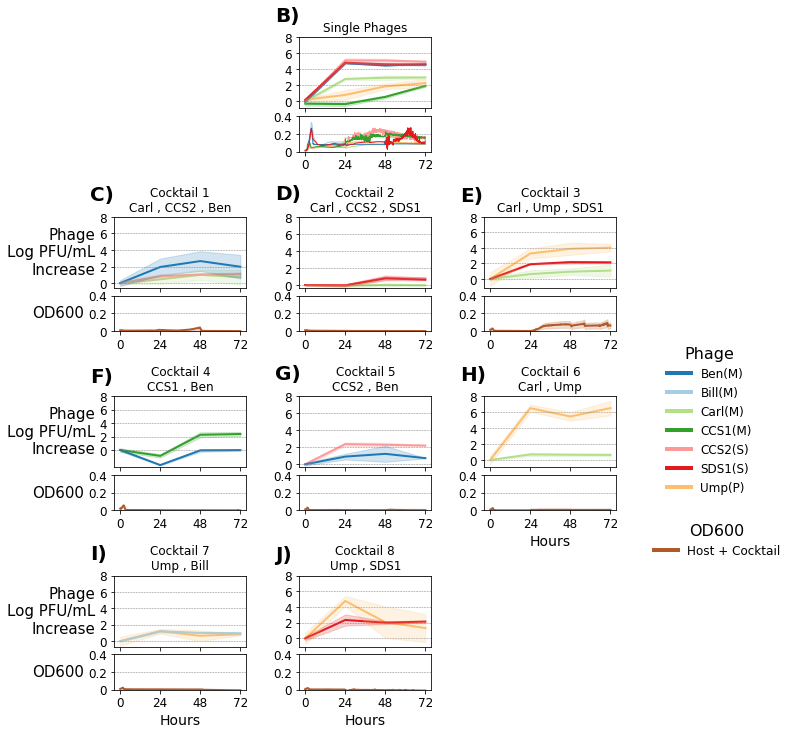

In [132]:
RIBBON_ALPHA=0.2
SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS = .7
qpcr_height = 1
od_height = .5

phage_color_dict= {"Ben(M)":'#1f78b4',
                  "Bill(M)":'#a6cee3',
                  "Carl(M)":'#b2df8a',
                  "CCS1(M)":'#33a02c',
                  "CCS2(S)":'#fb9a99',
                  "SDS1(S)":'#e31a1c',
                  "Ump(P)":'#fdbf6f'}
od_color_dict={"Host Control":"#6a3d9a",
              "Host + Cocktail":"#b15928"}
od_color_dict={"Host + Cocktail":"#b15928"}

fig,axs =  plt.subplots(11,3,
                        figsize=(9,12),
                       gridspec_kw={'height_ratios': [qpcr_height, od_height,SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS, 
                                                      qpcr_height, od_height, SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS, 
                                                      qpcr_height, od_height, SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS,
                                                      qpcr_height, od_height,]})

fig.subplots_adjust(wspace=.4, hspace=.15)
for j in [0,1,2]:
    axs[2,j].set_visible(False)
    axs[5,j].set_visible(False)
    axs[8,j].set_visible(False)
    

cocktail_list = ["Cocktail " + str(j) for j in range(1,9)]

# Do Single phages
single_phage_i = 1
single_phage_j = 0
for phage in set(single_qpcr_dat.Phage):
    #Get colors
    color_ = phage_color_dict[phage]
    #Get single phage data
    single_phage_tmp = single_qpcr_dat.query('Phage == @phage')
    single_phage_tmp_y = single_phage_tmp.avg.values
    single_phage_tmp_x = single_phage_tmp.timepoint.values
    axs[0,single_phage_i].plot(single_phage_tmp_x,single_phage_tmp_y, 
                  color=color_, zorder=1, linewidth=2)
    single_phage_tmp_x_perr = single_phage_tmp.avg + single_phage_tmp.SEM
    single_phage_tmp_x_nerr = single_phage_tmp.avg - single_phage_tmp.SEM
    axs[0,single_phage_i].fill_between(single_phage_tmp_x, single_phage_tmp_x_nerr, single_phage_tmp_x_perr, 
                              color= color_, alpha=RIBBON_ALPHA, zorder=2)
    #Qpcr title
    single_phage_od_y = single_od_dat.query('Phage==@phage').avg
    single_phage_od_x = single_od_dat.query('Phage==@phage').Hour
    axs[single_phage_j + 1,single_phage_i].plot(single_phage_od_x, single_phage_od_y,  color=color_, linewidth=1, linestyle='solid')
    
axs[single_phage_j,single_phage_i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
axs[single_phage_j+1,single_phage_i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
axs[single_phage_j,single_phage_i].set_title("Single Phages")

for i, cocktail in enumerate(cocktail_list):
    i += 3
    j = int(i/3) * 3
    i = i % 3
    
    #Subset data
    od_dat_ss = od_plot_dat.query('Cocktail == @cocktail')
    qpcr_dat_ss = qpcr_plot_dat.query('Cocktail == @cocktail')
    
    #Get x values
    od_x = od_dat_ss.Hour.values
    
    #Get y values for qpcr
    phage_y_values = {}
    phage_y_errp = {}
    phage_y_errn = {}
    phage_x = {}
    for phage in set(qpcr_dat_ss.phage_measured):
        #Subset data
        phage_ss = qpcr_dat_ss.query('phage_measured == @phage')
        #Get x values
        phage_x[phage] = phage_ss.timepoint.values
        #Get y values
        phage_y_values[phage] = phage_ss.value.values
        #Get y error
        phage_y_errp[phage] = phage_ss.errp.values
        phage_y_errn[phage] = phage_ss.errn.values
        #Get colors
        color_ = phage_color_dict[phage]
        
        #Plot error
        axs[j,i].fill_between(phage_x[phage], phage_y_errn[phage], phage_y_errp[phage], 
                              color= color_, alpha=RIBBON_ALPHA, zorder=2)
        
        #Plot line
        axs[j,i].plot(phage_x[phage],phage_y_values[phage], 
                      color=color_, zorder=1, linewidth=2)
        
        
    
    #Get y values for OD
    od_control_y = od_dat_ss.host_avg.values
    od_cocktail_y = od_dat_ss.value_avg.values
    #Get errors for OD
    od_control_y_sem = od_dat_ss.host_sem.values
    od_cocktail_y_sem = od_dat_ss.value_sem.values
    
    #Plot OD line
    #axs[j+1,i].plot(od_x, od_control_y,  color=od_color_dict["Host Control"], linewidth=2)
    axs[j+1,i].plot(od_x, od_cocktail_y, color=od_color_dict["Host + Cocktail"], linewidth=2)
    
    #Plor OD error
    #axs[j+1,i].fill_between(od_x, od_control_y - od_control_y_sem, od_control_y + od_control_y_sem, 
    #                        color=od_color_dict["Host Control"], alpha=RIBBON_ALPHA)
    axs[j+1,i].fill_between(od_x, od_cocktail_y - od_cocktail_y_sem, od_cocktail_y + od_cocktail_y_sem,
                            color=od_color_dict["Host + Cocktail"], alpha=RIBBON_ALPHA)
    
    #Qpcr title
    title_text = qpcr_dat_ss.Cocktail.values[0] + "\n" +  qpcr_dat_ss.formatted_cocktail_name.values[0]        
    axs[j,i].set_title(title_text)
    #axis grid
    axs[j,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    axs[j+1,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    
    #Add stats
    #stat_df = anova_df_sig.query('Cocktail==@cocktail')
    #if stat_df.shape[0] != 0:
    #    axs[j,i].scatter(stat_df.Hour, [7] * stat_df.shape[0] , marker="*", color="black")
    
#Adjust qpcr plot
for j in [0,3,6,9]:
    for i in [0,1,2]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].set_yticks( [0,2,4,6,8] )
        axs[j,i].set_yticklabels( [0,2,4,6,8] )
        axs[j,i].set_xticklabels( [] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        if i==0:
            axs[j,i].set_ylabel('Phage\nLog PFU/mL\nIncrease', size=15, rotation=0,
                                verticalalignment="center",horizontalalignment="right" )


#Adjust OD plot
for j in [1,4,7,10]:
    for i in [0,1,2]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        axs[j,i].set_ylim([0,.2])
        axs[j,i].set_yticks([0,.2,.4])
        axs[j,i].set_yticklabels( [0,.2,.4] )
        #Set x axis labels
        if j==10 or (j==7 and i==2) :
            axs[j,i].set_xlabel('Hours', size=14)
        else:
            axs[j,i].set_xlabel('', size=14)
        if i==0:
            axs[j,i].set_ylabel('OD600', size=15, rotation=0,
                                verticalalignment="center", horizontalalignment="right")
            
#Phage legend
legend_lines = [plt.Line2D([0],[0], color=c, lw=4) for c in phage_color_dict.values()]
legend_labels = [x for x in phage_color_dict.keys()]
phage_legend = plt.legend(legend_lines, legend_labels,
                  bbox_to_anchor=(1.3, 10), loc='upper left', 
                          prop={'size': 12}, title="Phage", frameon=False)
plt.setp(phage_legend.get_title(),fontsize=16)

#OD Legend
legend_lines2 = [plt.Line2D([0],[0], color=c, lw=4) for c in od_color_dict.values()]
legend_labels2 = [x for x in od_color_dict.keys()]
OD_legend = plt.legend(legend_lines2, legend_labels2,
                  bbox_to_anchor=(1.2, 5), loc='upper left', 
                          prop={'size': 12}, title="OD600", frameon=False)
plt.setp(OD_legend.get_title(),fontsize=16)
#Add back phage legend
plt.gca().add_artist(phage_legend)

alphabet = ["B)","C)","D)","E)","F)","G)","H)","I)","J)"]
alphabet_positions = [(0,1),(3,0),(3,1),(3,2),(6,0),(6,1),(6,2),(9,0),(9,1)]
for i in range(0,9):  
    axs[alphabet_positions[i]].text(x=-18, y=10, s=alphabet[i],size=20, fontweight="bold")
axs[0,0].axis('off')
axs[1,0].axis('off')
axs[0,2].axis('off')
axs[1,2].axis('off')
axs[9,2].axis('off')
axs[10,2].axis('off')
plt.savefig("figures/Qpcr_timecourse_fig_3_by_3_v2.png", bbox_inches='tight')

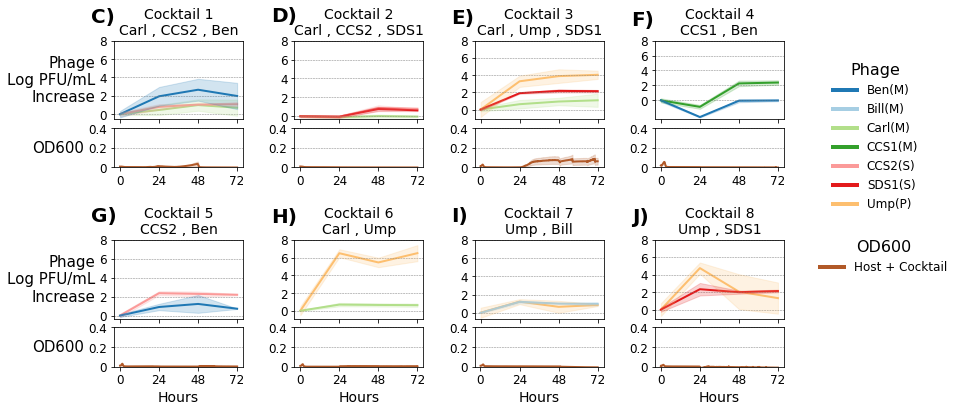

In [167]:
RIBBON_ALPHA=0.2
SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS = .7
qpcr_height = 1
od_height = .5

phage_color_dict= {"Ben(M)":'#1f78b4',
                  "Bill(M)":'#a6cee3',
                  "Carl(M)":'#b2df8a',
                  "CCS1(M)":'#33a02c',
                  "CCS2(S)":'#fb9a99',
                  "SDS1(S)":'#e31a1c',
                  "Ump(P)":'#fdbf6f'}
od_color_dict={"Host Control":"#6a3d9a",
              "Host + Cocktail":"#b15928"}
od_color_dict={"Host + Cocktail":"#b15928"}

fig,axs =  plt.subplots(5,4,
                        figsize=(12,6),
                       gridspec_kw={'height_ratios': [qpcr_height, od_height,SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS, qpcr_height, od_height]})

fig.subplots_adjust(wspace=.4, hspace=.15)
for j in [0,1,2,3]:
    axs[2,j].set_visible(False)

cocktail_list = ["Cocktail " + str(j) for j in range(1,9)]

for i, cocktail in enumerate(cocktail_list):
    j = int(i/4) * 3
    i = i % 4
    
    #Subset data
    od_dat_ss = od_plot_dat.query('Cocktail == @cocktail')
    qpcr_dat_ss = qpcr_plot_dat.query('Cocktail == @cocktail')
    
    #Get x values
    od_x = od_dat_ss.Hour.values
    
    #Get y values for qpcr
    phage_y_values = {}
    phage_y_errp = {}
    phage_y_errn = {}
    phage_x = {}
    for phage in set(qpcr_dat_ss.phage_measured):
        #Subset data
        phage_ss = qpcr_dat_ss.query('phage_measured == @phage')
        #Get x values
        phage_x[phage] = phage_ss.timepoint.values
        #Get y values
        phage_y_values[phage] = phage_ss.value.values
        #Get y error
        phage_y_errp[phage] = phage_ss.errp.values
        phage_y_errn[phage] = phage_ss.errn.values
        #Get colors
        color_ = phage_color_dict[phage]
        
        #Plot error
        axs[j,i].fill_between(phage_x[phage], phage_y_errn[phage], phage_y_errp[phage], 
                              color= color_, alpha=RIBBON_ALPHA, zorder=2)
        
        #Plot line
        axs[j,i].plot(phage_x[phage],phage_y_values[phage], 
                      color=color_, zorder=1, linewidth=2)
        
        
    
    #Get y values for OD
    od_control_y = od_dat_ss.host_avg.values
    od_cocktail_y = od_dat_ss.value_avg.values
    #Get errors for OD
    od_control_y_sem = od_dat_ss.host_sem.values
    od_cocktail_y_sem = od_dat_ss.value_sem.values
    
    #Plot OD line
    #axs[j+1,i].plot(od_x, od_control_y,  color=od_color_dict["Host Control"], linewidth=2)
    axs[j+1,i].plot(od_x, od_cocktail_y, color=od_color_dict["Host + Cocktail"], linewidth=2)
    
    #Plor OD error
    #axs[j+1,i].fill_between(od_x, od_control_y - od_control_y_sem, od_control_y + od_control_y_sem, 
    #                        color=od_color_dict["Host Control"], alpha=RIBBON_ALPHA)
    axs[j+1,i].fill_between(od_x, od_cocktail_y - od_cocktail_y_sem, od_cocktail_y + od_cocktail_y_sem,
                            color=od_color_dict["Host + Cocktail"], alpha=RIBBON_ALPHA)
    
    #Qpcr title
    title_text = qpcr_dat_ss.Cocktail.values[0] + "\n" +  qpcr_dat_ss.formatted_cocktail_name.values[0]        
    axs[j,i].set_title(title_text, size=14)
    #axis grid
    axs[j,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    axs[j+1,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    
    #Add stats
    #stat_df = anova_df_sig.query('Cocktail==@cocktail')
    #if stat_df.shape[0] != 0:
    #    axs[j,i].scatter(stat_df.Hour, [7] * stat_df.shape[0] , marker="*", color="black")
    
#Adjust qpcr plot
for j in [0,3]:
    for i in [0,1,2,3]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].set_yticks( [0,2,4,6,8] )
        axs[j,i].set_yticklabels( [0,2,4,6,8] )
        axs[j,i].set_xticklabels( [] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        if i==0:
            axs[j,i].set_ylabel('Phage\nLog PFU/mL\nIncrease', size=15, rotation=0,
                                verticalalignment="center",horizontalalignment="right" )


#Adjust OD plot
for j in [1,4]:
    for i in [0,1,2,3]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        axs[j,i].set_ylim([0,.2])
        axs[j,i].set_yticks([0,.2,.4])
        axs[j,i].set_yticklabels( [0,.2,.4] )
        #Set x axis labels
        if j ==4:
            axs[j,i].set_xlabel('Hours', size=14)
        else:
            axs[j,i].set_xlabel('', size=14)
        if i==0:
            axs[j,i].set_ylabel('OD600', size=15, rotation=0,
                                verticalalignment="center", horizontalalignment="right")
            
#Phage legend
legend_lines = [plt.Line2D([0],[0], color=c, lw=4) for c in phage_color_dict.values()]
legend_labels = [x for x in phage_color_dict.keys()]
phage_legend = plt.legend(legend_lines, legend_labels,
                  bbox_to_anchor=(1.3, 8), loc='upper left', 
                          prop={'size': 12}, title="Phage", frameon=False)
plt.setp(phage_legend.get_title(),fontsize=16)

#OD Legend
legend_lines2 = [plt.Line2D([0],[0], color=c, lw=4) for c in od_color_dict.values()]
legend_labels2 = [x for x in od_color_dict.keys()]
OD_legend = plt.legend(legend_lines2, legend_labels2,
                  bbox_to_anchor=(1.2, 3.5), loc='upper left', 
                          prop={'size': 12}, title="OD600", frameon=False)
plt.setp(OD_legend.get_title(),fontsize=16)
#Add back phage legend
plt.gca().add_artist(phage_legend)

alphabet = ["C)","D)","E)","F)","G)","H)","I)","J)"]
alphabet_positions = [(0,0),(0,1),(0,2),(0,3),(3,0),(3,1),(3,2),(3,3)]
for i in range(0,8):  
    axs[alphabet_positions[i]].text(x=-18, y=10, s=alphabet[i],size=20, fontweight="bold")
    
plt.savefig("figures/Qpcr_timecourse_fig_3_by_3_v2.png", bbox_inches='tight')

In [110]:
alphabet_positions[i]

(9, 1)

In [15]:
i

3

In [14]:
j

3